# **The Natural Experiment**

In 2017, CAHOOTS expanded service hours between 3:00 AM and 10:00 AM. To measure the divertibility of each call type we utilize the increase over baseline following the service hour expansion.

### Data Cleaning

In [108]:
# Import data
import pandas as pd 
file_path = r'D:\dsci\CAHOOTS\Data\call_data_from_CAD.csv'
CAD_data = pd.read_csv(file_path)

In [109]:

# Standardize Cahoots identifiers 
cahoots_identifiers = r"1J77\s*|3J79\s*|3J78\s*|3J77\s*|4J79\s*|3J81\s*|3J76\s*|2J28\s*|2J29\s*|CAHOOT\s*|CAHOT\s*|CAHO\s*"
CAD_data["PrimaryUnitCallSign"] = CAD_data["PrimaryUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)
CAD_data["RespondingUnitCallSign"] = CAD_data["RespondingUnitCallSign"].replace(cahoots_identifiers, 'CAHOOT', regex=True)

# Create an identifier for Cahoots involvement 
CAD_data['Cahoots_related'] = ((CAD_data['PrimaryUnitCallSign'] == 'CAHOOT') | (CAD_data['RespondingUnitCallSign'] == 'CAHOOT')).astype(int)

# Manage dt
CAD_data["Call_Created_Time"] = pd.to_datetime(CAD_data['Call_Created_Time'], errors='coerce')
CAD_data["Call_First_Dispatched_Time"] = pd.to_datetime(CAD_data['Call_First_Dispatched_Time'], errors='coerce')
CAD_data["Unit_OnScene_Time"] = pd.to_datetime(CAD_data['Unit_OnScene_Time'], errors='coerce')
CAD_data["year"] = CAD_data["Unit_OnScene_Time"].dt.year
CAD_data["hr"] = CAD_data["Unit_OnScene_Time"].dt.hour

CAD_data.dropna(subset="hr", inplace=True)
CAD_data.loc[:, "cahoots_handled"] = (CAD_data["Cahoots_related"] == 1) & (CAD_data["IsPrimary"] == 1)


CAD_data['InitialIncidentTypeDescription'] = CAD_data['InitialIncidentTypeDescription'].replace("ASSIST PUBLIC- POLICE", "ASSIST PUBLIC")
# Drop unneeded cols
CAD_data = CAD_data.drop(columns=['Unnamed: 0', 'Beat', 'Unit_Cleared_Time'])

In [110]:
# Drop non-public CFS
CAD_data = CAD_data[CAD_data["Call_Source"] != "SELF"]
CAD_data = CAD_data[CAD_data["Call_Source"] != "RPTO"]

# Drop duplicates and NA
CAD_data = CAD_data.drop_duplicates()
CAD_data = CAD_data.dropna(subset=["PrimaryUnitCallSign", "RespondingUnitCallSign"], how='all')

# Only include calls in Eugene 
zip_codes = [97402.0, 97401.0, 97405.0, 97404.0, 97403.0, 97408.0]
CAD_data = CAD_data[CAD_data['Call_Zipcode'].isin(zip_codes)]

# Remove 2022 and 2023 until data errors can be fixed
CAD_data = CAD_data[~CAD_data["year"].isin([2022.0, 2023.0, 2024.0])]

In [111]:
# Marked for future import factoring 

def filter_df_by_time(df, start_time=None, end_time=None, time_column='Call_Created_Time'):
    """
    Filters the dataframe based on the time range specified by the user

    Parameters:
    df to filter
    start_time (str)
    end_time (str)
    time_column (str): The name of the column containing datetime values

    """
    df.loc[:, time_column] = pd.to_datetime(df[time_column])

    if start_time:
        if len(start_time) == 4:  # if only a year is given
            start_time = pd.to_datetime(f"{start_time}-01-01")
    else:
        start_time = df[time_column].min() 

    if end_time:
        if len(end_time) == 4:  
            end_time = pd.to_datetime(f"{end_time}-12-31 23:59:59")
    else:
        end_time = df[time_column].max()  

    filtered_df = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)]

    return filtered_df

def dataset_builder(data, dispatched=False, arrived=False, solo_cahoots=False, time=None):
    """
    Parameters:
    time (list of strings) [start time, end time, time_col]
    
    """
    # Apply time range if specified
    if time:
        data = filter_df_by_time(data, time[0], time[1], time[2])
    
    # Dispatched filter is based on "Unit_Dispatched_Time"
    if dispatched:
        data = data[data["Unit_Dispatched_Time"].notna()]
    
    # Arrived filter is based on "Call_First_Dispatched_Time"
    if arrived:
        data = data[data["Unit_OnScene_Time"].notna()]
        data = data[data["Unit_Dispatched_Time"].notna()]
        
    # Only Include CAHOOTS calls where no other agencies are involved
    if solo_cahoots:
        data = data[~((data['PrimaryUnitCallSign'] == 'CAHOOTS') & (data['IsPrimary'] == 0))]
        
    return data

In [112]:
# Build Datasets

CAD_2016 = dataset_builder(CAD_data, dispatched=False, arrived=False, time=['2016', '2016', 'Call_Created_Time'])
CAD_2017 = dataset_builder(CAD_data, dispatched=False, arrived=False, time=['2017', '2017', 'Call_Created_Time'])

CAD_2016_nat = CAD_2016[(CAD_2016["hr"] >= 3) & (CAD_2016["hr"] <= 6)]
CAD_2017_nat = CAD_2017[(CAD_2017["hr"] >= 3) & (CAD_2017["hr"] <= 6)]

combined_nat = dataset_builder(CAD_data, dispatched=False, arrived=False, time=['2016', '2021', 'Call_Created_Time'])

In [113]:
combined_nat[(combined_nat["Cahoots_related"] == 0) & (combined_nat["InitialIncidentTypeDescription"] == "ASSIST PUBLIC")]

IncidentNumber   Call_Created_Time  \
2548     OR-2020-01-01-20000470 2020-01-01 13:55:02   
2655     OR-2020-01-01-20000662 2020-01-01 17:35:46   
2656     OR-2020-01-01-20000662 2020-01-01 17:35:46   
5959     OR-2019-01-02-19001467 2019-01-02 15:07:53   
6014     OR-2019-01-02-19001559 2019-01-02 16:48:24   
...                         ...                 ...   
1614531  OR-2019-12-31-19339093 2019-12-31 14:11:52   
1615618  OR-2021-12-31-21336311 2021-12-31 11:30:56   
1615619  OR-2021-12-31-21336311 2021-12-31 11:30:56   
1615719  OR-2021-12-31-21336466 2021-12-31 14:54:19   
1615720  OR-2021-12-31-21336466 2021-12-31 14:54:19   

        Call_First_Dispatched_Time  Call_First_On_Scene         Call_Cleared  \
2548           2020-01-01 13:57:20  01/01/2020 13:57:20  01/01/2020 14:59:24   
2655           2020-01-01 17:36:40  01/01/2020 17:38:22  01/01/2020 18:02:07   
2656           2020-01-01 17:36:40  01/01/2020 17:38:22  01/01/2020 18:02:07   
5959           2019-01-02 15:17:51  01/02/2019 15:18:59  01/02/2019 15:38:13   
6014           2019-01-02 16:57:49  01/02/2019 16:57:49  01/02/2019 16:57:51   
...                            ...                  ...                  ...   
1614531        2019-12-31 14:50:58  12/31/2019 14:51:03  12/31/2019 15:19:33   
1615618        2021-12-31 11:35:45  12/31/2021 11:35:50  12/31/2021 13:29:23   
1615619        2021-12-31 11:35:45  12/31/2021 11:35:50  12/31/2021 13:29:23   
1615719        2021-12-31 15:25:19  12/31/2021 15:25:19  12/31/2021 15:42:32   
1615720        2021-12-31 15:25:19  12/31/2021 15:25:19  12/31/2021 15:42:32   

         Call_Zipcode Call_Source Call_Priority  \
2548          97401.0       PHONE             5   
2655          97401.0       PHONE             P   
2656          97401.0       PHONE             P   
5959          97401.0       PHONE             3   
6014          97401.0       PHONE             5   
...               ...         ...           ...   
1614531       97401.0       PHONE             5   
1615618       97401.0       PHONE             8   
1615619       97401.0       PHONE             8   
1615719       97401.0       PHONE             5   
1615720       97401.0       PHONE             5   

        InitialIncidentTypeDescription  IsPrimary PrimaryUnitCallSign  \
2548                     ASSIST PUBLIC          1                2W81   
2655                     ASSIST PUBLIC          0                3E14   
2656                     ASSIST PUBLIC          1                3E14   
5959                     ASSIST PUBLIC          1                3E27   
6014                     ASSIST PUBLIC          1                2W78   
...                                ...        ...                 ...   
1614531                  ASSIST PUBLIC          1                1X11   
1615618                  ASSIST PUBLIC          0                3W81   
1615619                  ASSIST PUBLIC          1                3W81   
1615719                  ASSIST PUBLIC          0                3W90   
1615720                  ASSIST PUBLIC          1                3W90   

        RespondingUnitCallSign Unit_Dispatched_Time   Unit_OnScene_Time  \
2548                      2W81  01/01/2020 13:57:20 2020-01-01 13:57:20   
2655                      3E32  01/01/2020 17:36:40 2020-01-01 17:38:22   
2656                      3E14  01/01/2020 17:36:40 2020-01-01 17:39:28   
5959                      3E27  01/02/2019 15:17:51 2019-01-02 15:18:59   
6014                      2W78  01/02/2019 16:57:49 2019-01-02 16:57:49   
...                        ...                  ...                 ...   
1614531                   1X11  12/31/2019 14:50:58 2019-12-31 14:51:03   
1615618                   3W81  12/31/2021 11:35:45 2021-12-31 11:35:50   
1615619                   3W81  12/31/2021 11:35:45 2021-12-31 11:35:50   
1615719                   3E72  12/31/2021 15:25:19 2021-12-31 15:25:19   
1615720                   3W90  12/31/2021 15:25:57 2021-12-31 15:34:35   

    

In [114]:
combined_nat = dataset_builder(CAD_data, dispatched=False, arrived=False, time=['2016', '2021', 'Call_Created_Time'])
cahoots_calls_by_hr_2016 = (
    CAD_2016[
        (CAD_2016["Cahoots_related"] == 1) & (CAD_2016["IsPrimary"] == 1)
    ]
    .groupby('hr')
    .size()
    .reindex(range(24), fill_value=0)
    .reset_index(name='count')
)

cahoots_calls_by_hr_2017 = (
    CAD_2017[
        (CAD_2017["Cahoots_related"] == 1) & (CAD_2017["IsPrimary"] == 1)
    ]
    .groupby('hr')
    .size()
    .reindex(range(24), fill_value=0)
    .reset_index(name='count')
)
#cahoots_calls_by_hr

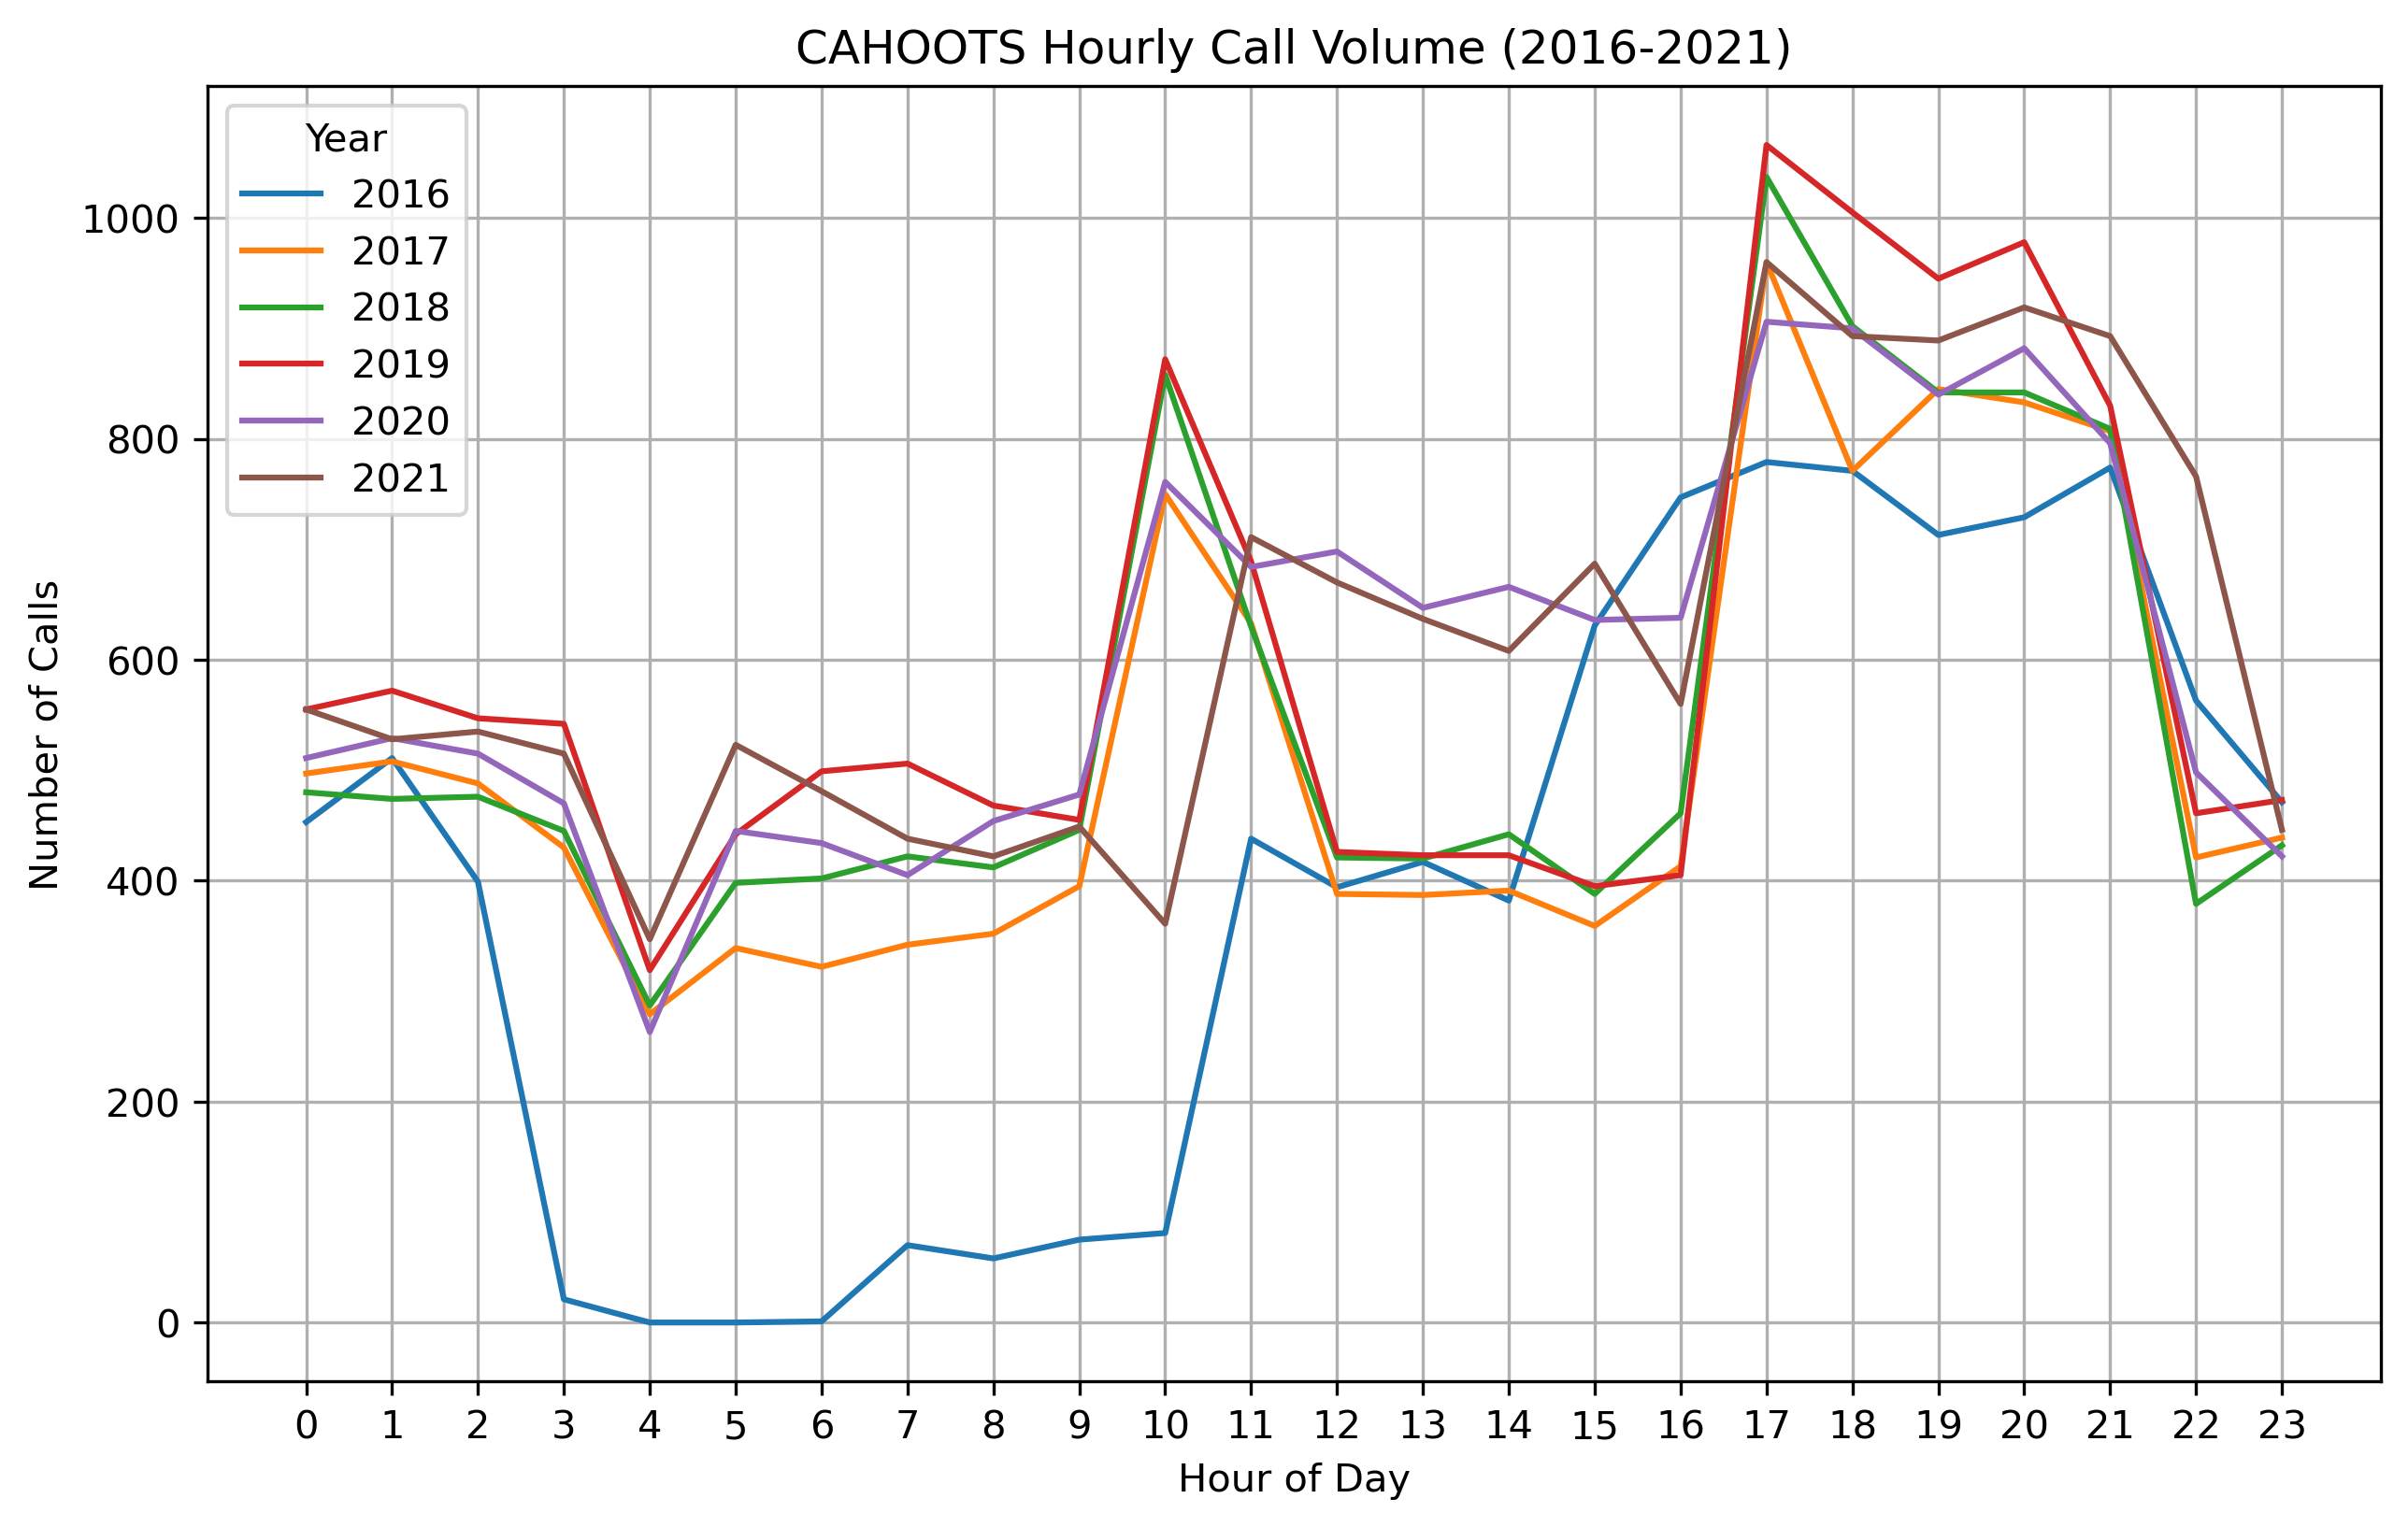

In [115]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

# Create a dictionary to hold dataframes for each year
cahoots_calls_by_hr = {}

# Iterate through each year and build the dataset and hourly call volume
for year in range(2016, 2022):
    # Build the dataset for the specified year
    CAD_year = dataset_builder(CAD_data, dispatched=False, arrived=False, time=[str(year), str(year), 'Call_Created_Time'])
    
    # Filter the data for Cahoots-related and primary calls and group by hour
    cahoots_calls_by_hr[year] = (
        CAD_year[
            (CAD_year["Cahoots_related"] == 1) & (CAD_year["IsPrimary"] == 1)
        ]
        .groupby('hr')
        .size()
        .reindex(range(24), fill_value=0)  # Ensure every hour is represented, even if there are no calls
        .reset_index(name='count')
    )

# Set up a plot with one line for each year
plt.figure(figsize=(10, 6))

# Plot the hourly call volume for each year
for year, df in cahoots_calls_by_hr.items():
    plt.plot(df['hr'], df['count'], label=str(year))

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Number of Calls')
plt.title('CAHOOTS Hourly Call Volume (2016-2021)')
plt.xticks(range(24))
plt.legend(title='Year')
plt.grid(True)
plt.show()


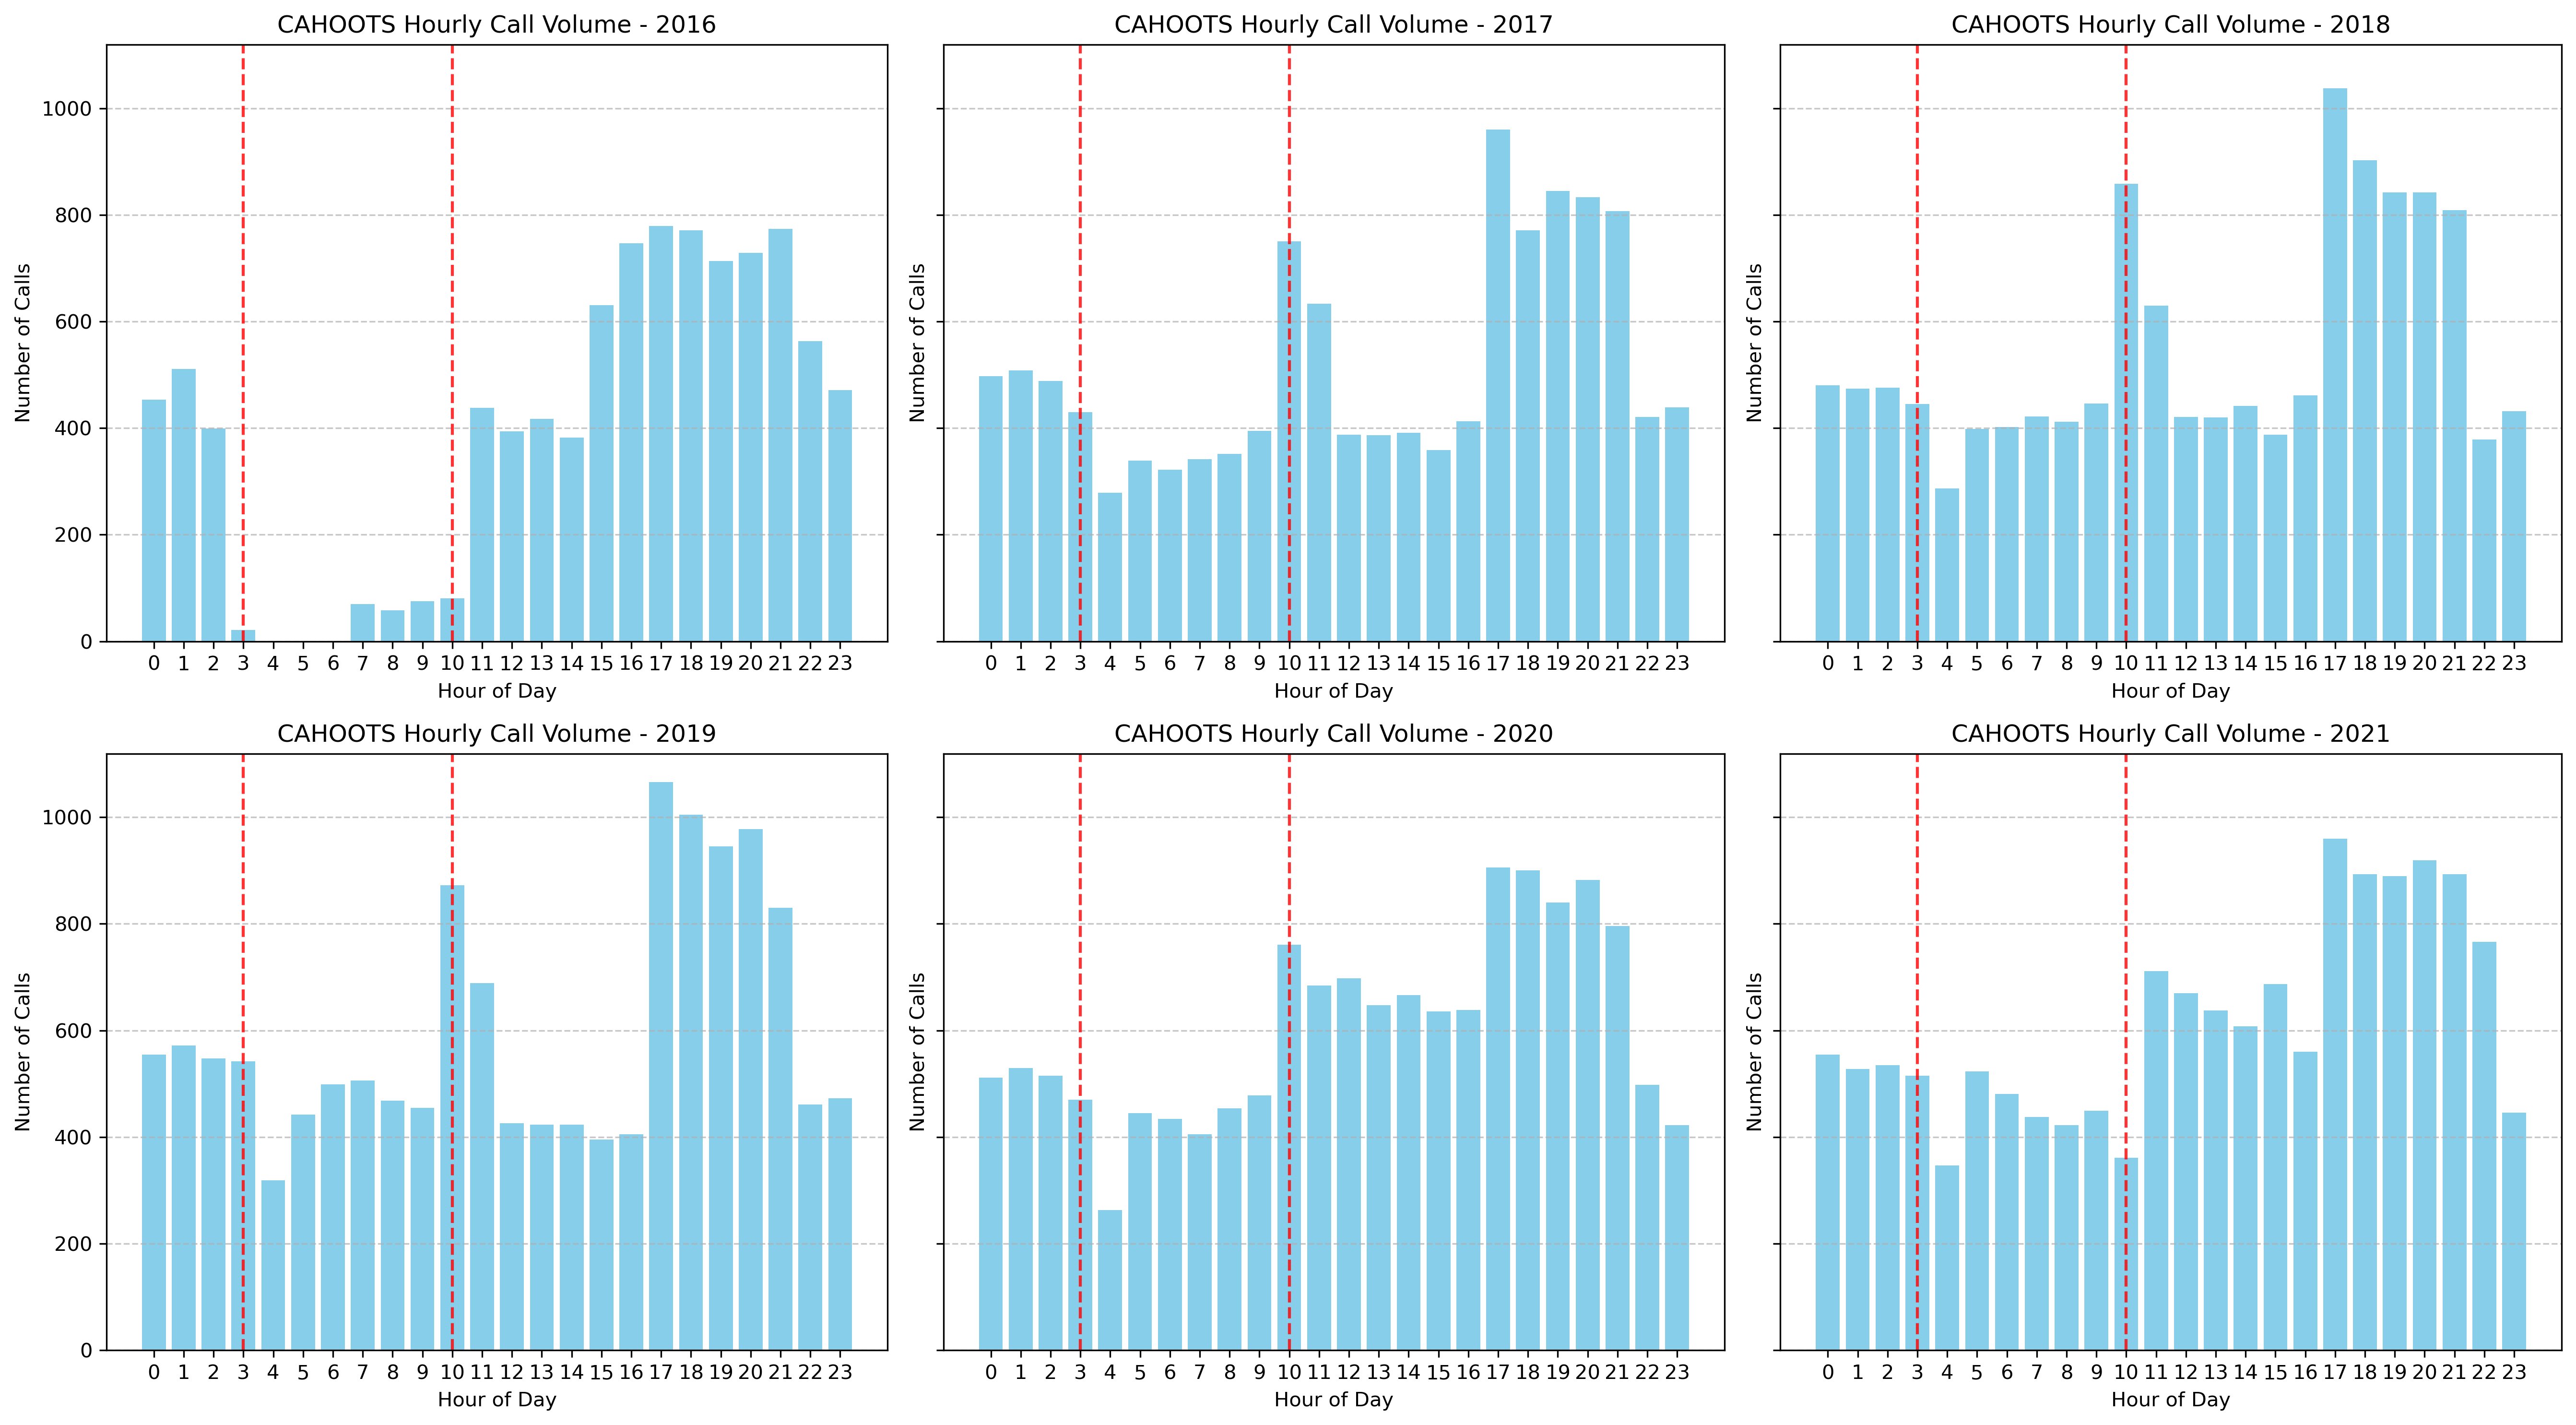

In [116]:
import matplotlib.pyplot as plt

# Create a dictionary to hold dataframes for each year
cahoots_calls_by_hr = {}

# Iterate through each year and build the dataset and hourly call volume
for year in range(2016, 2022):
    # Build the dataset for the specified year
    CAD_year = dataset_builder(CAD_data, dispatched=False, arrived=False, time=[str(year), str(year), 'Call_Created_Time'])
    
    # Filter the data for Cahoots-related and primary calls and group by hour
    cahoots_calls_by_hr[year] = (
        CAD_year[
            (CAD_year["Cahoots_related"] == 1) & (CAD_year["IsPrimary"] == 1)
        ]
        .groupby('hr')
        .size()
        .reindex(range(24), fill_value=0)  # Ensure every hour is represented, even if there are no calls
        .reset_index(name='count')
    )

# Create subplots: 2 rows, 3 columns (for 6 subplots: 2016-2021)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot each year in its corresponding subplot
for ax, (year, df) in zip(axes, cahoots_calls_by_hr.items()):
    ax.bar(df['hr'], df['count'], color='skyblue')
    ax.set_title(f'CAHOOTS Hourly Call Volume - {year}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Number of Calls')
    ax.set_xticks(range(24))  # Set x-ticks for each hour
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability

    # Add dashed vertical lines on either side of 3am (3) to 10am (10)
    ax.axvline(x=3, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.axvline(x=10, color='red', linestyle='--', linewidth=1.5, alpha=0.8)

# Adjust layout
plt.tight_layout()
plt.show()


# Total Call volume for welfare checks by hour 2016-2017

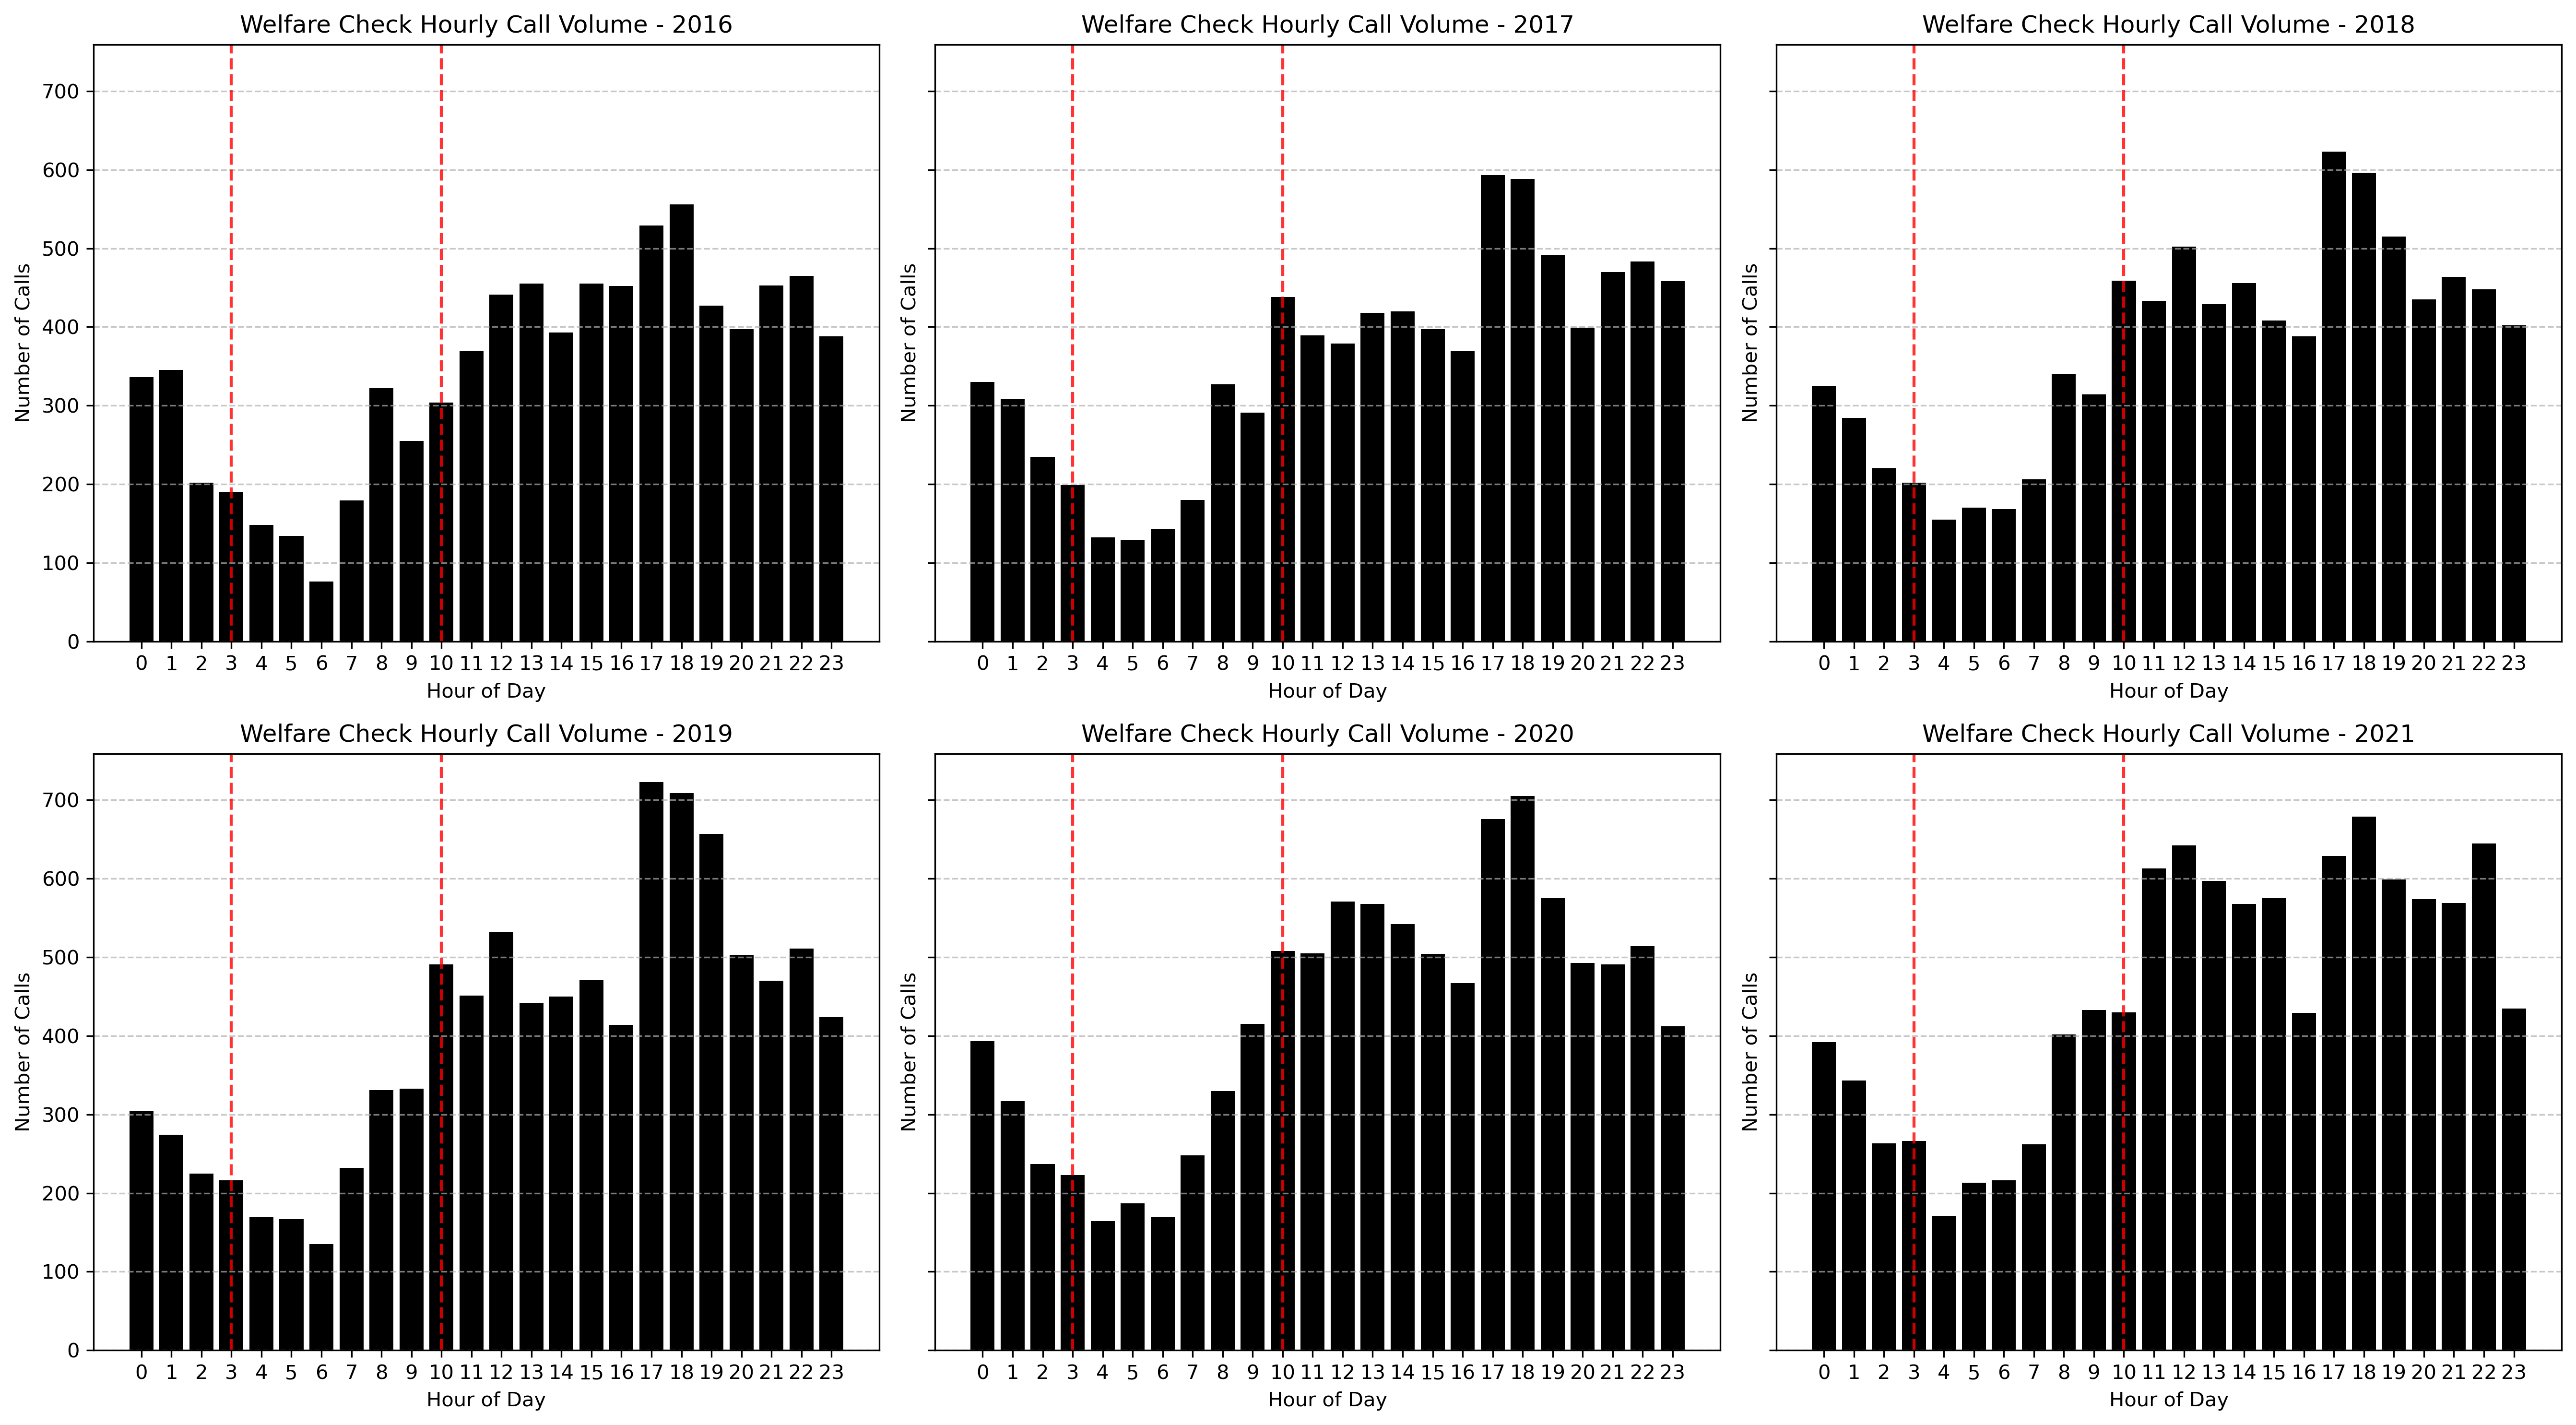

In [117]:
import matplotlib.pyplot as plt

# Create a dictionary to hold dataframes for each year
welfare_calls_by_hr = {}

for year in range(2016, 2022):
    # Build the dataset for the specified year
    CAD_year = dataset_builder(CAD_data, dispatched=False, arrived=False, time=[str(year), str(year), 'Call_Created_Time'])
    
    # Filter the data for "CHECK WELFARE" calls and group by hour
    welfare_calls_by_hr[year] = (
        CAD_year[
            CAD_year["InitialIncidentTypeDescription"] == "CHECK WELFARE"
        ]
        .groupby('hr')
        .size()
        .reindex(range(24), fill_value=0)  # Ensure every hour is represented, even if there are no calls
        .reset_index(name='count')
    )

# Create subplots: 2 rows, 3 columns (for 6 subplots: 2016-2021)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharey=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot each year in its corresponding subplot
for ax, (year, df) in zip(axes, welfare_calls_by_hr.items()):
    ax.bar(df['hr'], df['count'], color='black')
    ax.set_title(f'Welfare Check Hourly Call Volume - {year}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Number of Calls')
    ax.set_xticks(range(24))  # Set x-ticks for each hour
    ax.grid(axis='y', linestyle='--', alpha=0.7)  

    # Add dashed vertical lines on either side of 3am to 10am 
    ax.axvline(x=3, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
    ax.axvline(x=10, color='red', linestyle='--', linewidth=1.5, alpha=0.8)

# Adjust layout
plt.tight_layout()
plt.show()


# Total Call volume for top CAHOOTS Incident types by hour - 2016-2021

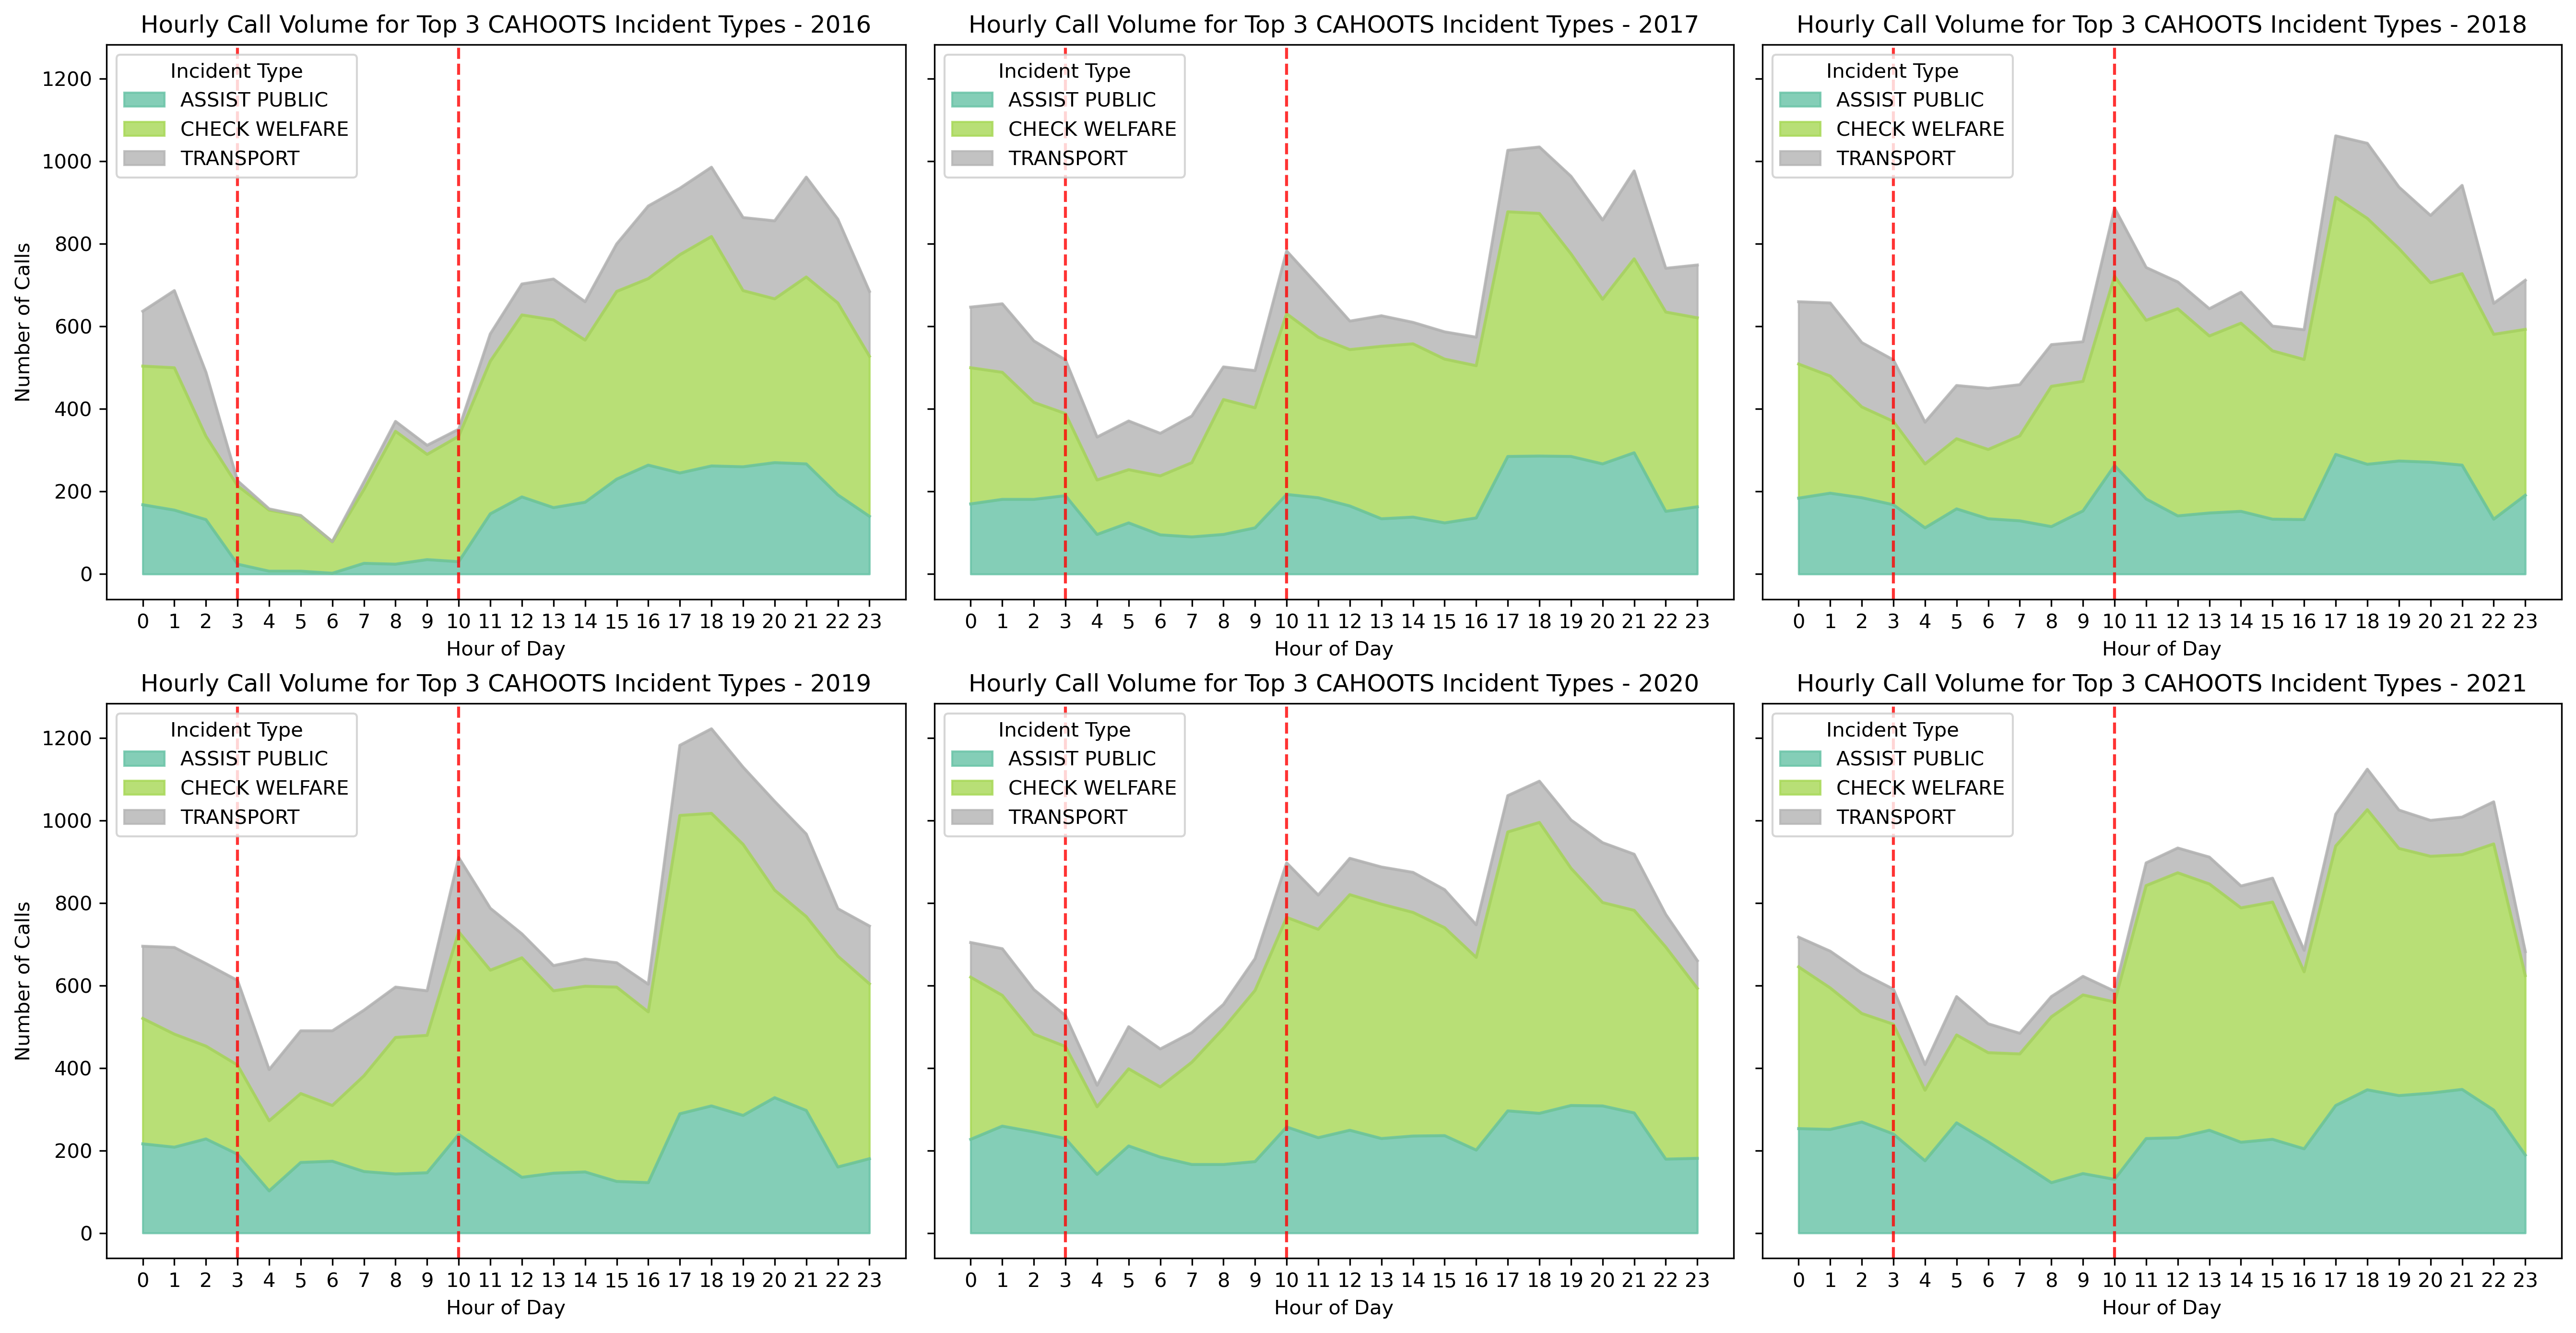

In [118]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_stacked_area_top_incidents(data, year_range, top_n_incidents=5):
    """
    Plot stacked area plots of hourly call volumes for the top N incident types over a range of years.

    Parameters:
    data (pd.DataFrame): The dataset containing call data.
    year_range (tuple): A tuple specifying the range of years to include, e.g., (2016, 2021).
    top_n_incidents (int): The number of top incident types to include in the plot.

    """
    # Identify the top N most frequent CAHOOTS-related call types
    top_incident_types = (
        data[data["Cahoots_related"] == 1]
        .groupby("InitialIncidentTypeDescription")
        .size()
        .nlargest(top_n_incidents)
        .index
    )

    # Create a dataframe to hold all hourly call volumes for the top N incident types
    area_data = []

    # Iterate through each year and each incident type to collect data
    for year in range(year_range[0], year_range[1] + 1):
        # Filter data for the current year
        data_year = data[data['Call_Created_Time'].dt.year == year]

        # For each of the top N incident types, collect hourly call volume data
        for incident_type in top_incident_types:
            # Filter data for the specific incident type
            filtered_data = data_year[data_year["InitialIncidentTypeDescription"] == incident_type]

            # Group by hour and calculate the hourly volume
            hourly_volume = (
                filtered_data.groupby("hr")
                .size()
                .reindex(range(24), fill_value=0)  # Ensure every hour is represented
                .reset_index(name='count')
            )

            # Store the data in a list for creating a dataframe later
            for hr, count in zip(hourly_volume['hr'], hourly_volume['count']):
                area_data.append([year, incident_type, hr, count])

    area_df = pd.DataFrame(area_data, columns=['Year', 'Incident Type', 'Hour', 'Call Volume'])

    # Pivot the data to create a stacked area plot
    pivot_df = area_df.pivot_table(values='Call Volume', index='Hour', columns=['Year', 'Incident Type'], fill_value=0)

    # Create a stacked area plot for each year
    num_years = year_range[1] - year_range[0] + 1
    nrows = (num_years + 2) // 3  # Calculate number of rows needed for subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(18, nrows * 5), sharey=True)
    axes = axes.flatten() 

    # Plot a stacked area plot for each year
    for ax, year in zip(axes, range(year_range[0], year_range[1] + 1)):
        # Extract the data for the current year
        if year in pivot_df.columns.levels[0]:
            year_data = pivot_df[year]
            
            # Plot a stacked area plot for the top N incident types
            year_data.plot(kind='area', stacked=True, ax=ax, cmap='Set2', alpha=0.8)

            ax.set_title(f'Hourly Call Volume for Top {top_n_incidents} CAHOOTS Incident Types - {year}')
            ax.set_xlabel('Hour of Day')
            ax.set_ylabel('Number of Calls')
            ax.set_xticks(range(24))  # Ensure all hours (0-23) are shown on the x-axis
            ax.legend(title='Incident Type', loc='upper left')
            ax.grid(False)

            # Draw dashed vertical lines 
            ax.axvline(x=3, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
            ax.axvline(x=10, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
        else:
            ax.set_visible(False)  # Hide the subplot if the year is not in the range

    # Hide any remaining unused subplots if year range is smaller than subplot grid
    for i in range(num_years, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.90) 
    plt.show()

plot_stacked_area_top_incidents(CAD_data, year_range=(2016, 2021), top_n_incidents=3)


### Fisher's Exact Test Per Call Type 3am - 6am

In [119]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import warnings

# Suppress specific FutureWarnings from Seaborn (Optional)
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# 1. Filter Data for 3 am - 6 am
filtered_data = combined_nat[(combined_nat['hr'] >= 3) & (combined_nat['hr'] <= 6)]

# Define the function to analyze a given time period
def analyze_period(filtered_data, pre_year, post_year):
    # 2. Segment Data into Pre-Expansion and Post-Expansion Periods
    pre_expansion = filtered_data[filtered_data['year'] == pre_year]
    post_expansion = filtered_data[filtered_data['year'] == post_year]
    
    # 3. Calculate Total Calls in Pre and Post Periods
    total_pre_calls = pre_expansion.shape[0]
    total_post_calls = post_expansion.shape[0]
    
    # 4. Calculate Total Calls for Each Call Type
    # Pre-Expansion
    pre_calls = pre_expansion.groupby('InitialIncidentTypeDescription').size().reset_index(name='pre_call_count')
    
    # Post-Expansion
    post_calls = post_expansion.groupby('InitialIncidentTypeDescription').size().reset_index(name='post_call_count')
    
    # 5. Merge Pre and Post DataFrames
    call_volume_comparison = pd.merge(pre_calls, post_calls, on='InitialIncidentTypeDescription', how='left').fillna(0)
    
    # 6. Compute Absolute and Percentage Changes
    call_volume_comparison['absolute_change'] = call_volume_comparison['post_call_count'] - call_volume_comparison['pre_call_count']
    call_volume_comparison['percentage_change'] = (call_volume_comparison['absolute_change'] / call_volume_comparison['pre_call_count'].replace(0, np.nan)) * 100
    
    # Replace infinite values resulting from division by zero with NaN
    call_volume_comparison.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 7. Statistical Significance Testing using Fisher's Exact Test
    # Initialize an empty list to store results
    statistical_results = []
    
    for index, row in call_volume_comparison.iterrows():
        A = row['pre_call_count']
        B = row['post_call_count']
        C = total_pre_calls - A
        D = total_post_calls - B
    
        # Build contingency table
        contingency_table = np.array([[A, B],
                                      [C, D]])
    
        # Ensure all values are integers
        contingency_table = contingency_table.astype(int)
    
        # Check if the contingency table is valid
        if contingency_table.min() < 0:
            # Invalid contingency table
            p_value = np.nan
        else:
            # Perform Fisher's Exact Test (use 'two-sided' alternative)
            _, p_value = fisher_exact(contingency_table, alternative='two-sided')
    
        # Append results
        statistical_results.append({
            'InitialIncidentTypeDescription': row['InitialIncidentTypeDescription'],
            'p_value': p_value
        })
    
    # Create a DataFrame with Statistical Results
    stats_df = pd.DataFrame(statistical_results)
    
    # Merge with the call_volume_comparison DataFrame
    call_volume_comparison = pd.merge(call_volume_comparison, stats_df, on='InitialIncidentTypeDescription')
    
    # 8. Calculate Proportion of CAHOOTS-handled Calls
    # Filter post-expansion data for CAHOOTS-handled calls
    cahoots_calls = post_expansion[post_expansion['cahoots_handled'] == True]
    
    # Count CAHOOTS calls by Call Type
    cahoots_call_counts = cahoots_calls.groupby('InitialIncidentTypeDescription').size().reset_index(name='cahoots_call_count')
    
    # Merge with call_volume_comparison DataFrame
    call_volume_comparison = pd.merge(call_volume_comparison, cahoots_call_counts, on='InitialIncidentTypeDescription', how='left').fillna(0)
    
    # Calculate the proportion of CAHOOTS-handled calls
    call_volume_comparison['cahoots_proportion'] = (call_volume_comparison['cahoots_call_count'] / call_volume_comparison['post_call_count'].replace(0, np.nan)) * 100
    
    # 9. Classify Call Types Based on Divertibility
    # Define conditions for classification
    conditions = [
        (call_volume_comparison['p_value'] >= 0.05),  # No significant change
        (call_volume_comparison['p_value'] < 0.05) & (call_volume_comparison['absolute_change'] > 0),  # Significant increase
        (call_volume_comparison['p_value'] < 0.05) & (call_volume_comparison['absolute_change'] < 0)  # Significant decrease
    ]
    
    # Define the categories
    categories = ['No significant change', 'Significant increase', 'Significant decrease']
    
    # Create a new column for classification
    call_volume_comparison['divertibility_classification'] = np.select(conditions, categories, default='No Data')
    
    # 10. Calculate Total Calls for Sorting and Selection
    call_volume_comparison['total_calls'] = call_volume_comparison['pre_call_count'] + call_volume_comparison['post_call_count']
    
    return call_volume_comparison

# Analysis for 2016-2017
call_volume_comparison_16_17 = analyze_period(filtered_data, pre_year=2016, post_year=2017)

# Analysis for 2017-2018
call_volume_comparison_17_18 = analyze_period(filtered_data, pre_year=2017, post_year=2018)

# Analysis for 2018-2019
call_volume_comparison_18_19 = analyze_period(filtered_data, pre_year=2018, post_year=2019)

# The DataFrame for 2016-2017 remains identical to the original
call_volume_comparison_16_17


InitialIncidentTypeDescription  pre_call_count  post_call_count  \
0                 ABANDONED VEHICLE               2              0.0   
1                     ACCIDENT BIKE               1              1.0   
2             ACCIDENT VEHICLE BIKE               1              4.0   
3                             ALARM              11             11.0   
4                      ALARM DURESS              24             18.0   
..                              ...             ...              ...   
141  VIOLATION OF RESTRAINING ORDER              25             29.0   
142                        WALKAWAY               1              0.0   
143                 WARRANT SERVICE              21             21.0   
144                    WATER RESCUE               1              0.0   
145                WRONG WAY DRIVER               2              9.0   

     absolute_change  percentage_change   p_value  cahoots_call_count  \
0               -2.0             -100.0  0.200557                 0.0   
1                0.0                0.0  1.000000                 1.0   
2                3.0              300.0  0.388432                 0.0   
3                0.0                0.0  0.671394                 0.0   
4               -6.0              -25.0  0.120743                 0.0   
..               ...                ...       ...                 ...   
141              4.0               16.0  0.891179                 0.0   
142             -1.0             -100.0  0.447856                 0.0   
143              0.0                0.0  0.536071                 0.0   
144             -1.0             -100.0  0.447856                 0.0   
145              7.0              350.0  0.126111                 0.0   

     cahoots_proportion divertibility_classification  total_calls  
0                   NaN        No significant change          2.0  
1                 100.0        No significant change          2.0  
2                   0.0        No significant change          5.0  
3                   0.0        No significant change         22.0  
4                   0.0        No significant change         42.0  
..                  ...                          ...          ...  
141                 0.0        No significant change         54.0  
142                 NaN        No significant change          1.0  
143                 0.0        No significant change         42.0  
144                 NaN        No significant change          1.0  
145                 0.0        No significant change         11.0  

[146 rows x 10 columns]

In [120]:
# Import necessary libraries (if not already imported)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
from adjustText import adjust_text  # Import adjustText

# Define the visualization function
def visualize_calls(call_volume_comparison, top_n=100, label_threshold=300, title='Pre vs Post Expansion Call Counts for Top Incident Types'):
    # 1. Define the Number of Top Call Types to Visualize and Label Threshold
    # 'top_n' and 'label_threshold' are parameters

    # 2. Select the Top 'top_n' Incident Types by Total Calls
    top_incidents = call_volume_comparison.nlargest(top_n, 'total_calls').copy()

    # 3. Determine Statistical Significance for Color Coding
    # Assign colors based on statistical significance of increase or decrease
    def determine_color(row):
        if row['p_value'] < 0.05 and row['absolute_change'] > 0:
            return 'seagreen'  # Significant Increase
        elif row['p_value'] < 0.05 and row['absolute_change'] < 0:
            return 'indianred'  # Significant Decrease
        else:
            return 'grey'  # No Significant Change

    # Apply the color determination function to each row
    top_incidents['color'] = top_incidents.apply(determine_color, axis=1)

    # 4. Create the Scatter Plot
    plt.figure(figsize=(16, 10)) 
    size_min = 100  # Minimum marker size
    size_max = 1000  # Maximum marker size

    scatter = sns.scatterplot(
        data=top_incidents,
        x='pre_call_count',
        y='post_call_count',
        hue='color',  
        size='absolute_change',
        sizes=(size_min, size_max),
        palette={'seagreen': 'seagreen', 'indianred': 'indianred', 'grey': 'grey'},
        edgecolor='black',
        alpha=0.7,
        legend=False  
    )

    # 5. Add Reference Line 
    max_val = max(top_incidents['pre_call_count'].max(), top_incidents['post_call_count'].max()) * 1.05  # Add 5% buffer
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

    # 6. Set Labels and Title
    plt.xlabel('Pre-Expansion Call Count', fontsize=14)
    plt.ylabel('Post-Expansion Call Count', fontsize=14)
    plt.title(title, fontsize=16)

    # 7. Annotate Points with Incident Type Descriptions using adjustText
    label_mode = 'call_count'  # Options: 'top_n' or 'call_count'
    texts = []  # List to hold text annotations

    # Define a fixed padding in points
    padding = 14  # points

    # Get min and max absolute_change for normalization
    min_abs_change = top_incidents['absolute_change'].min()
    max_abs_change = top_incidents['absolute_change'].max()

    # Function to map absolute_change to marker size
    def map_size(abs_change):
        # Normalize absolute_change to [0,1]
        if max_abs_change == min_abs_change:
            norm = 0.5
        else:
            norm = (abs_change - min_abs_change) / (max_abs_change - min_abs_change)
        # Map to marker size
        return size_min + norm * (size_max - size_min)

    # Store the original positions and texts for later use
    positions = []
    for idx, row in top_incidents.iterrows():
        if label_mode == 'top_n' or (label_mode == 'call_count' and row['total_calls'] >= label_threshold):
            abs_change = row['absolute_change']
            # Handle negative sizes for consistent offset
            abs_change_positive = abs(abs_change) if abs_change != 0 else 1  # Avoid sqrt(0)
            # Map absolute_change to marker size
            marker_size = map_size(abs_change_positive)
            # Calculate marker radius in points
            marker_radius = np.sqrt(marker_size) / 2
            # Total offset in points: radius + padding
            total_offset = marker_radius + padding
            # Create text annotation without arrows
            text = plt.text(
                row['pre_call_count'], row['post_call_count'],
                row['InitialIncidentTypeDescription'],
                fontsize=9,
                ha='left',  # Align text to the left
                va='center',
                bbox=dict(facecolor='white', alpha=1, edgecolor='black', pad=2)
            )
            texts.append(text)
            # Store the original position
            positions.append((row['pre_call_count'], row['post_call_count']))

    # Adjust text labels to avoid overlaps without drawing arrows
    adjust_text(
        texts,
        only_move={'texts': 'xy'},
        expand_text=(1.2, 1.2),
        force_text=(0.5, 0.5),
        lim=1000
    )

    # Now, manually draw arrows from the points to the text labels
    for pos, text in zip(positions, texts):
        start_x, start_y = pos
        end_x, end_y = text.get_position()
        # Only draw an arrow if the text has moved significantly
        if np.hypot(end_x - start_x, end_y - start_y) > 0.01:
            arrow = plt.Arrow(
                start_x, start_y,
                end_x - start_x, end_y - start_y,
                width=0.1,
                color='black',
                zorder=2  # Draw behind the text
            )
            plt.gca().add_patch(arrow)

    # 8. Customize Legends
    # a. Create custom legend handles for color 
    color_legend_elements = [
        Patch(facecolor='seagreen', edgecolor='seagreen', label='Significant Increase'),
        Patch(facecolor='indianred', edgecolor='indianred', label='Significant Decrease'),
        Patch(facecolor='grey', edgecolor='grey', label='No Significant Change')
    ]

    # b. Create custom legend handles for size (Absolute Change)
    # Define some representative sizes
    size_values = [50, 200, 500, 800]  # Adjust based on your data
    size_labels = [50, 200, 500, 800]

    # Create legend handles using Line2D
    size_legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=f'{size}',
               markersize=np.sqrt(size)/2, markerfacecolor='grey', markeredgecolor='black', alpha=0.7)
        for size in size_values
    ]

    # c. Create the legends
    first_legend = plt.legend(handles=color_legend_elements, title='Statistical Significance',
                              fontsize=12, title_fontsize=12, loc='center left', bbox_to_anchor=(0.8, 0.3))
    second_legend = plt.legend(handles=size_legend_elements, title='Absolute Change',
                               fontsize=12, title_fontsize=12, loc='center left', bbox_to_anchor=(0.857, 0.15))

    # d. Add the first legend back to the plot
    plt.gca().add_artist(first_legend)

    plt.subplots_adjust(right=1)  # Add more space on the right side for legends
    plt.tight_layout()

    plt.show()


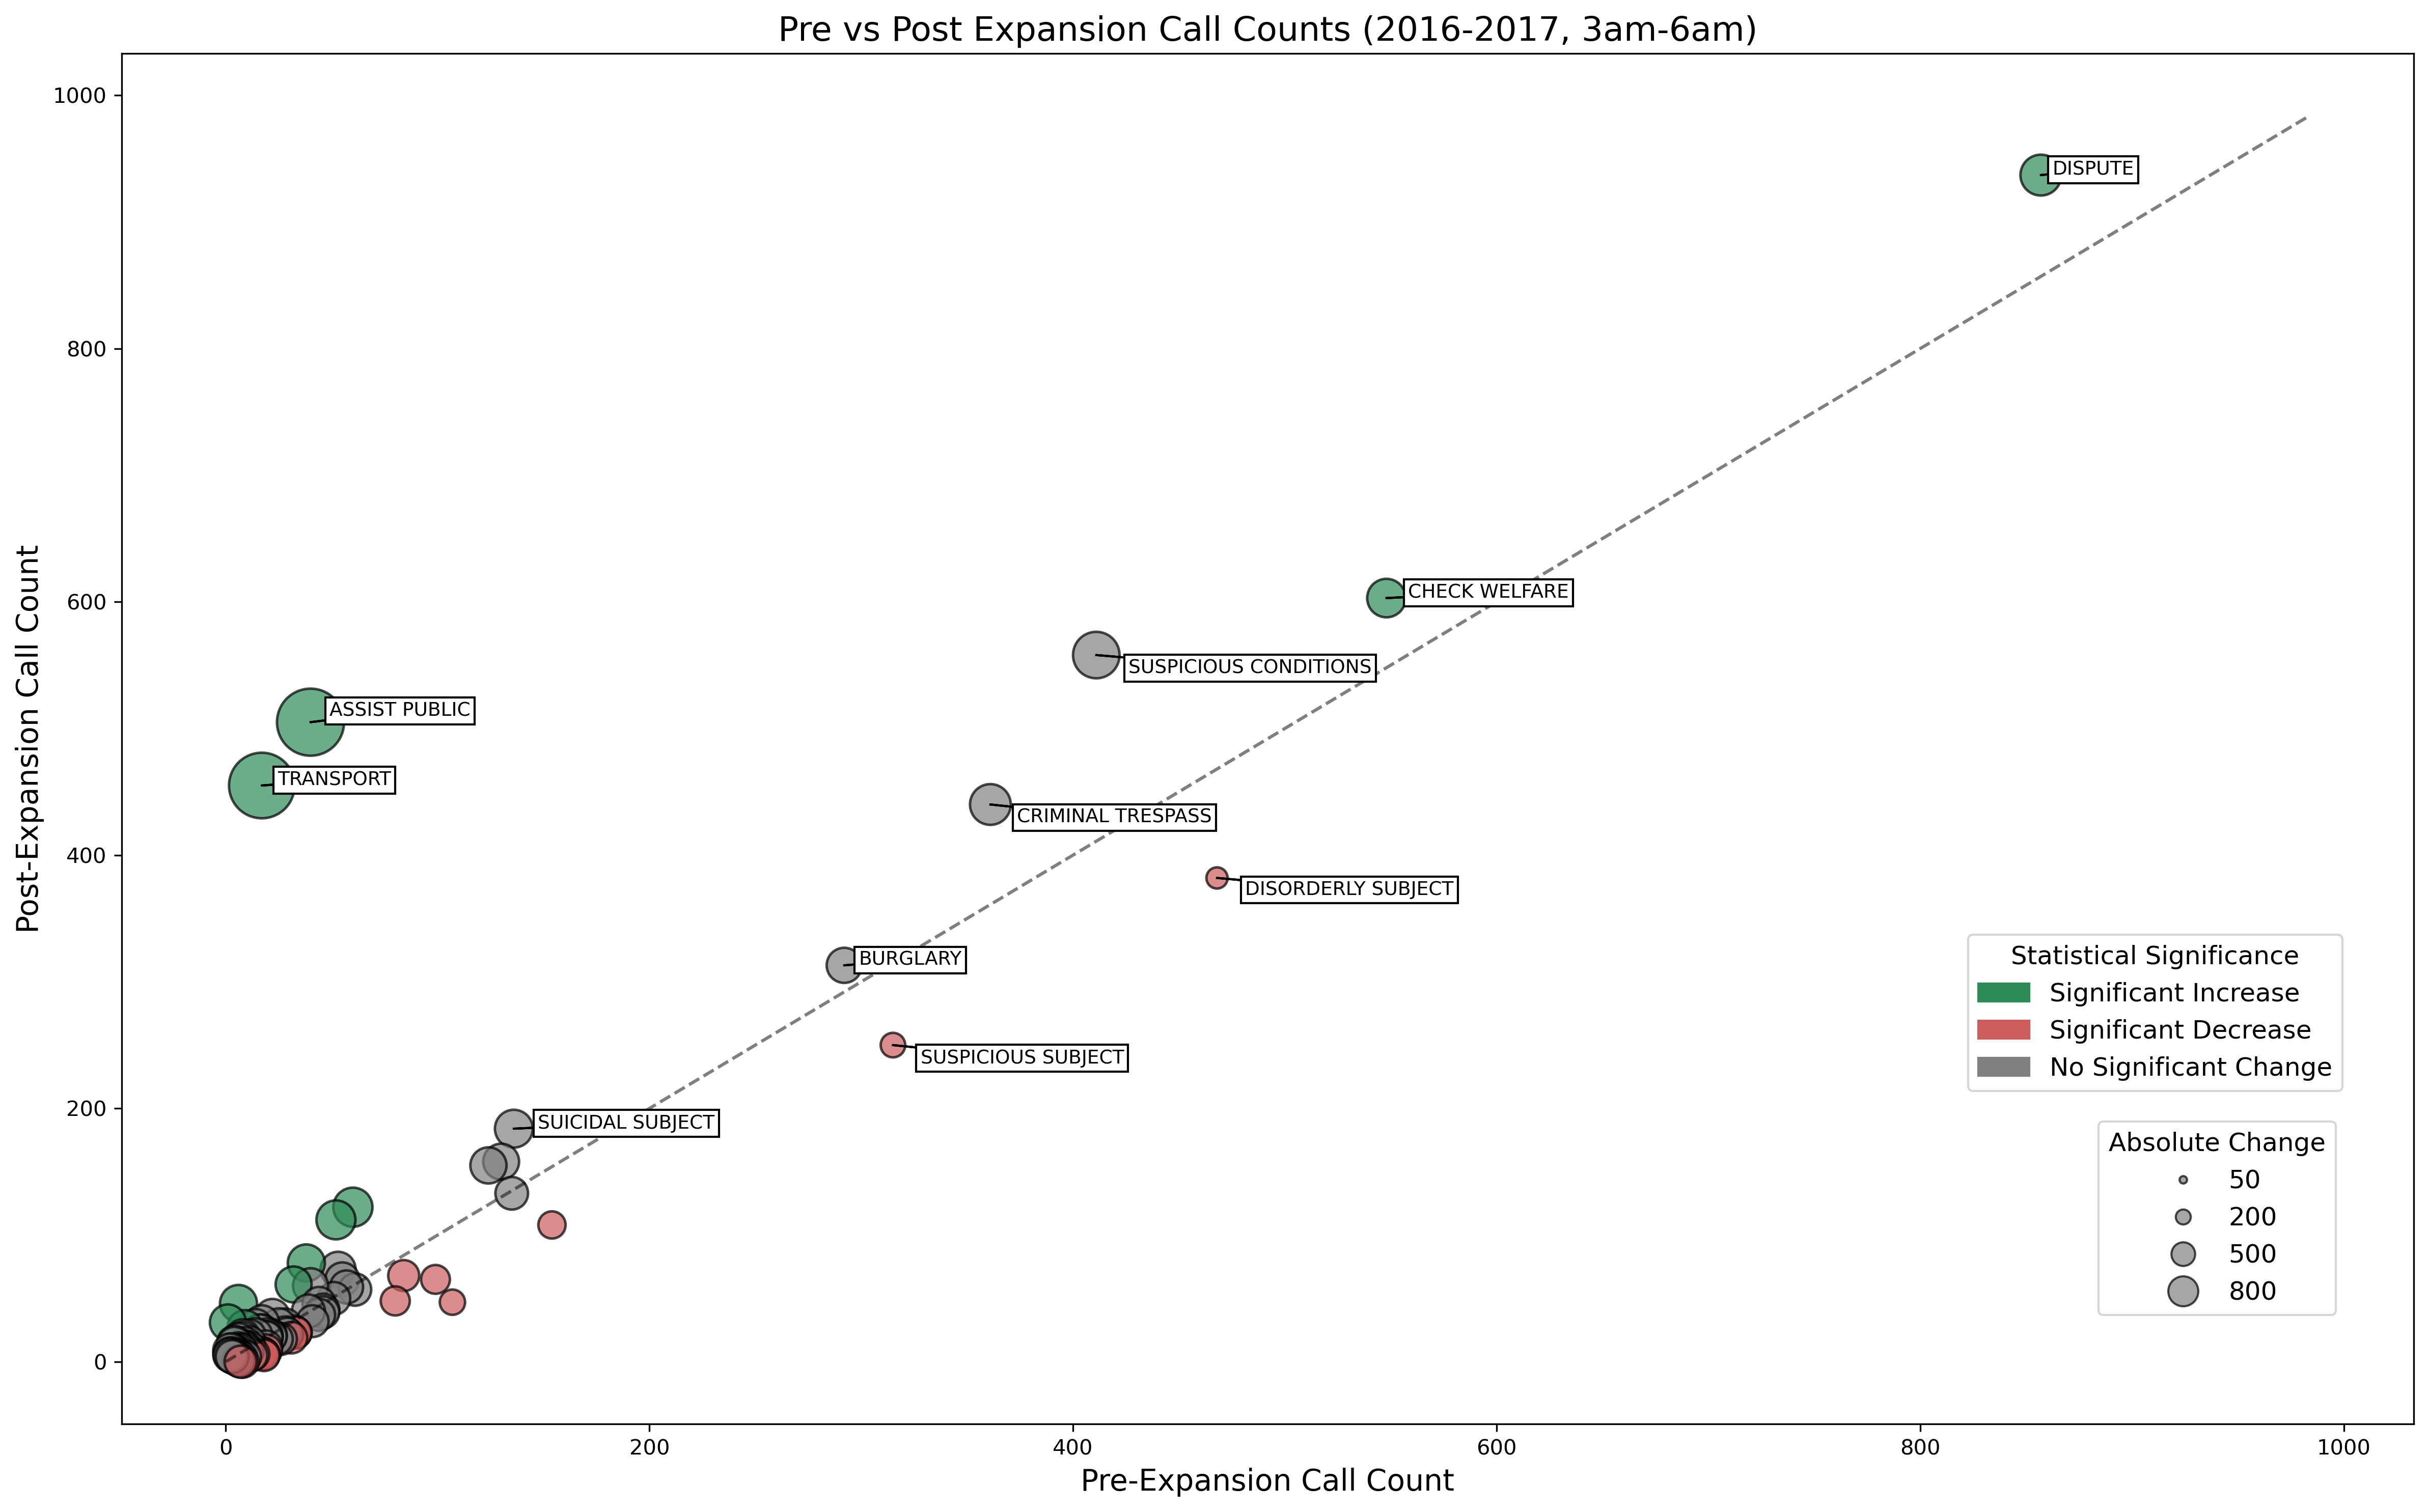

In [121]:
visualize_calls(
    call_volume_comparison_16_17,
    top_n=100,
    label_threshold=300,
    title='Pre vs Post Expansion Call Counts (2016-2017, 3am-6am)'
)

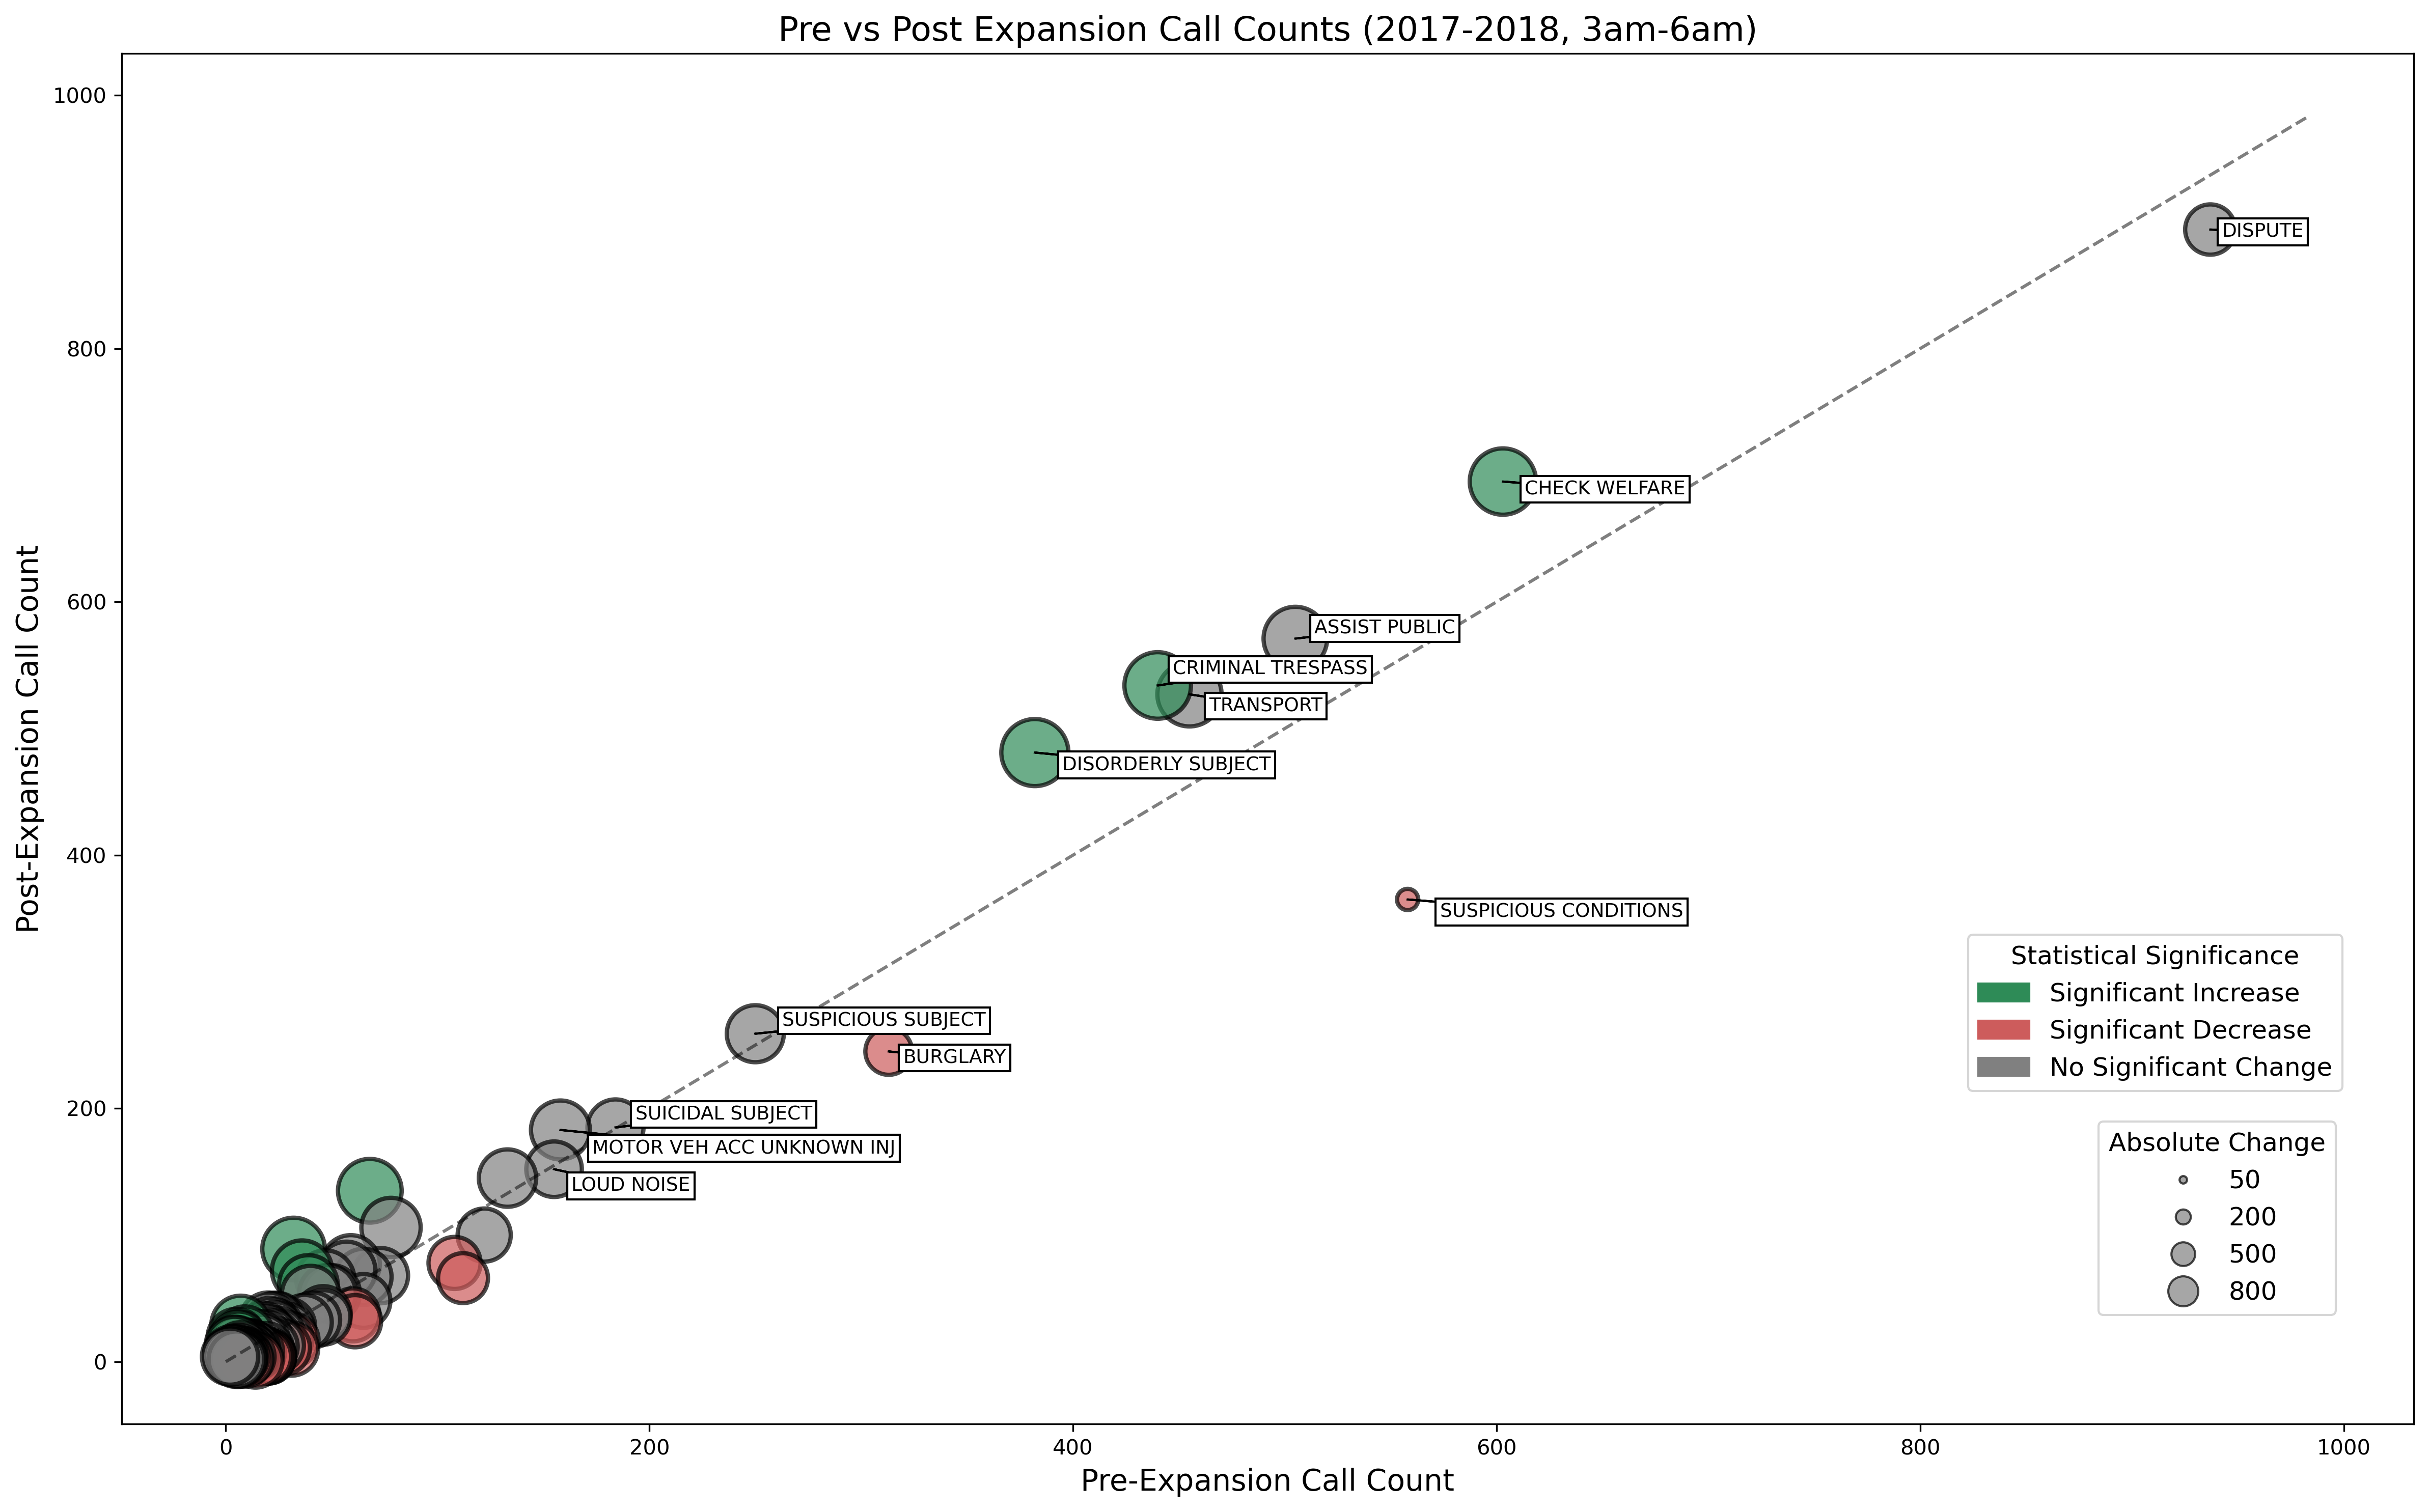

In [122]:
visualize_calls(
    call_volume_comparison_17_18,
    top_n=100,
    label_threshold=300,
    title='Pre vs Post Expansion Call Counts (2017-2018, 3am-6am)'
)

The EPD claims that a certain portion of CAHOOTS centric call types are not actually divertible, which could artificially inflate the diversion rate. The EPD argues that many of these calls are outside the scope of traditional police work and that these calls would not exist, if not for CAHOOTS. Our goal is to determine on a per call type basis, what proportion of those call types are likely diversions. If the existence of CAHOOTS were truly creating a large number of non-police relevant calls, we would expect to see a substantial increase in typical CAHOOTS call types following the service hour expansion, and larger increases in call types with fewer police relevant calls. 

If a call type did not see a statistically significant increase during the service hour expansion, we conclude that CAHOOTS is not adding non-police mandate calls to that particular call type and offer no adjustments. Additionally, if CAHOOTS did not handle any calls from a particular call type, they could not have been the cause of the increase so we filter out any call types with no CAHOOTS involvement. 

In [123]:
cahoots_relevant_call_volume_comparison = call_volume_comparison[(call_volume_comparison["divertibility_classification"] == "Significant increase") &
                       (call_volume_comparison["cahoots_proportion"] > 0)].copy()
cahoots_relevant_call_volume_comparison[["InitialIncidentTypeDescription", "divertibility_classification", "p_value"]]

InitialIncidentTypeDescription divertibility_classification       p_value
18                   ASSIST PUBLIC         Significant increase  1.664337e-86
27                   CHECK WELFARE         Significant increase  4.403652e-02
43                         DISPUTE         Significant increase  6.868047e-03
57                   FOUND SYRINGE         Significant increase  3.606235e-07
119              SUBJECT SCREAMING         Significant increase  6.539345e-04
131                 TRAFFIC HAZARD         Significant increase  1.213009e-03
133                      TRANSPORT         Significant increase  1.866413e-95

This leaves us with 7 call types where CAHOOTS is potentially adding non-police mandate calls. Since we know that the EPD was responding to all calls in the pre-expansion period, we have a baseline that is divertible by definition. We now use this increase above baseline as an estimate for the proportion of non-divertible calls

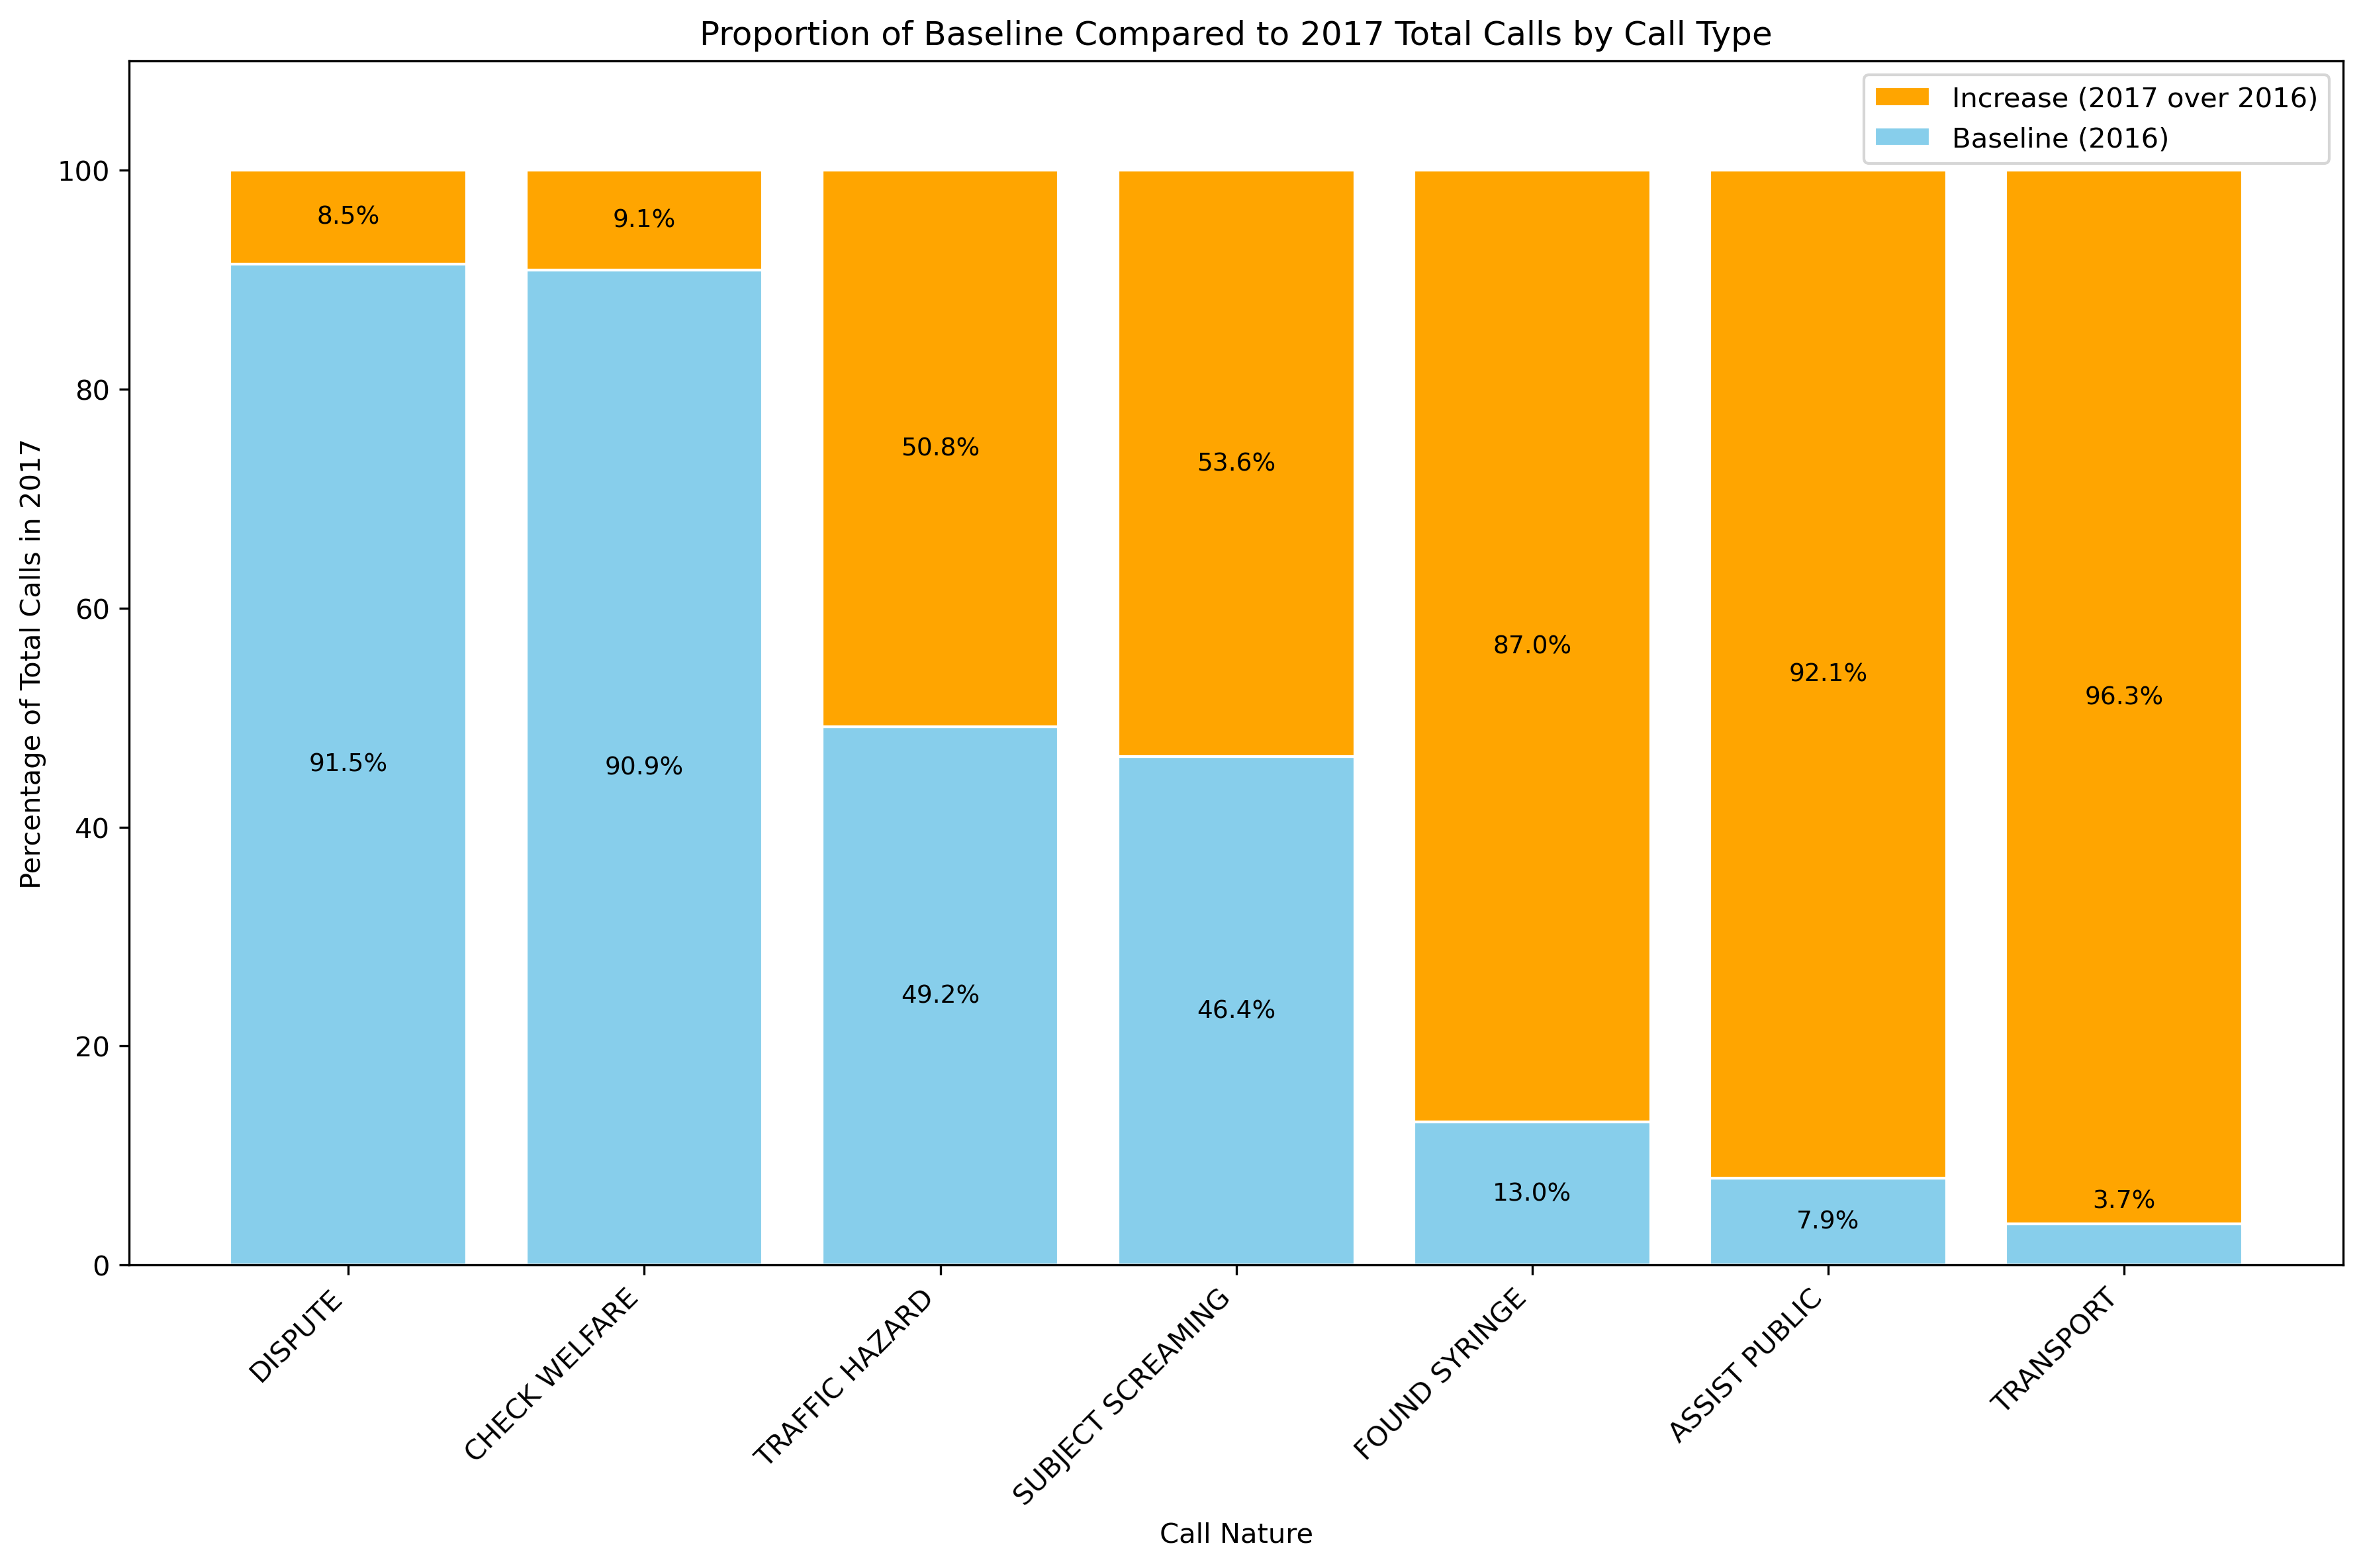

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'cahoots_relevant_call_volume_comparison' is your DataFrame
df = cahoots_relevant_call_volume_comparison.copy()

# Calculate the increase above the baseline for each call type
df['increase'] = df['post_call_count'] - df['pre_call_count']

# Calculate the percentages
df['baseline_percentage'] = (df['pre_call_count'] / df['post_call_count']) * 100
df['increase_percentage'] = (df['increase'] / df['post_call_count']) * 100

# Prepare data for plotting
df_plot = df.set_index('InitialIncidentTypeDescription')

# Sort the DataFrame by baseline_percentage in descending order for better visualization
df_plot = df_plot.sort_values(by='baseline_percentage', ascending=False)

# Plotting the 100% stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the baseline and increase as proportions
bottoms = np.zeros(len(df_plot))
call_types = df_plot.index

# Colors for the stacked bars
colors = ['skyblue', 'orange']

# Plot baseline percentages
bars1 = ax.bar(call_types, df_plot['baseline_percentage'], bottom=bottoms, color=colors[0], edgecolor='white', label='Baseline (2016)')
bottoms += df_plot['baseline_percentage']

# Plot increase percentages
bars2 = ax.bar(call_types, df_plot['increase_percentage'], bottom=bottoms, color=colors[1], edgecolor='white', label='Increase (2017 over 2016)')

# Adding percentage labels
for idx, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Get the values using iloc
    baseline_pct = df_plot['baseline_percentage'].iloc[idx]
    increase_pct = df_plot['increase_percentage'].iloc[idx]
    
    # Get positions
    bar1_height = bar1.get_height()
    bar2_height = bar2.get_height()
    bar1_y = bar1.get_y()
    bar2_y = bar2.get_y()
    
    # Set label positions
    if baseline_pct > 5:
        ax.text(bar1.get_x() + bar1.get_width() / 2, bar1_y + bar1_height / 2,
                f"{baseline_pct:.1f}%", ha='center', va='center', color='black', fontsize=9)
    else:
        # Place small percentages outside the bar
        ax.text(bar1.get_x() + bar1.get_width() / 2, bar1_y + bar1_height + 1,
                f"{baseline_pct:.1f}%", ha='center', va='bottom', color='black', fontsize=9)
    if increase_pct > 5:
        ax.text(bar2.get_x() + bar2.get_width() / 2, bar2_y + bar2_height / 2,
                f"{increase_pct:.1f}%", ha='center', va='center', color='black', fontsize=9)
    else:
        # Place small percentages outside the bar
        ax.text(bar2.get_x() + bar2.get_width() / 2, bar2_y + bar2_height + 1,
                f"{increase_pct:.1f}%", ha='center', va='bottom', color='black', fontsize=9)

# Customize the plot
ax.set_xlabel('Call Nature')
ax.set_ylabel('Percentage of Total Calls in 2017')
ax.set_title('Proportion of Baseline Compared to 2017 Total Calls by Call Type')
ax.set_ylim(0, 110)  # Add extra space for labels above bars

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust legend to match the order of the stack bars (top to bottom)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])  # Reverse the order of legend items

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


# Diversions Corrected For Non-police mandate CAHOOTS Calls

In [125]:
CAD_data 

IncidentNumber   Call_Created_Time  \
0        OR-2016-01-01-16000001 2016-01-01 00:00:04   
1        OR-2016-01-01-16000001 2016-01-01 00:00:04   
2        OR-2016-01-01-16000001 2016-01-01 00:00:04   
5        OR-2016-01-01-16000004 2016-01-01 00:02:45   
6        OR-2016-01-01-16000004 2016-01-01 00:02:45   
...                         ...                 ...   
1616014  OR-2021-12-31-21336924 2021-12-31 23:22:08   
1616015  OR-2021-12-31-21336924 2021-12-31 23:22:08   
1616017  OR-2021-12-31-21336927 2021-12-31 23:26:57   
1616018  OR-2021-12-31-21336927 2021-12-31 23:26:57   
1616019  OR-2021-12-31-21336927 2021-12-31 23:26:57   

        Call_First_Dispatched_Time  Call_First_On_Scene         Call_Cleared  \
0              2016-01-01 00:04:58  01/01/2016 00:09:41  01/01/2016 00:54:19   
1              2016-01-01 00:04:58  01/01/2016 00:09:41  01/01/2016 00:54:19   
2              2016-01-01 00:04:58  01/01/2016 00:09:41  01/01/2016 00:54:19   
5              2016-01-01 00:04:05  01/01/2016 00:04:05  01/01/2016 00:18:22   
6              2016-01-01 00:04:05  01/01/2016 00:04:05  01/01/2016 00:18:22   
...                            ...                  ...                  ...   
1616014        2021-12-31 23:45:17  12/31/2021 23:50:59  01/01/2022 00:11:43   
1616015        2021-12-31 23:45:17  12/31/2021 23:50:59  01/01/2022 00:11:43   
1616017        2021-12-31 23:27:54  12/31/2021 23:30:24  01/01/2022 00:03:11   
1616018        2021-12-31 23:27:54  12/31/2021 23:30:24  01/01/2022 00:03:11   
1616019        2021-12-31 23:27:54  12/31/2021 23:30:24  01/01/2022 00:03:11   

         Call_Zipcode Call_Source Call_Priority  \
0             97402.0        E911             3   
1             97402.0        E911             3   
2             97402.0        E911             3   
5             97401.0        E911             3   
6             97401.0        E911             3   
...               ...         ...           ...   
1616014       97401.0        E911             3   
1616015       97401.0        E911             3   
1616017       97402.0        E911             3   
1616018       97402.0        E911             3   
1616019       97402.0        E911             3   

        InitialIncidentTypeDescription  IsPrimary PrimaryUnitCallSign  \
0                              ASSAULT          1                5E57   
1                              ASSAULT          0                5E57   
2                              ASSAULT          0                5E57   
5                        CHECK WELFARE          0                3X90   
6                        CHECK WELFARE          0                3X90   
...                                ...        ...                 ...   
1616014                    SHOTS FIRED          0                4E66   
1616015                    SHOTS FIRED          1                4E66   
1616017             DISORDERLY SUBJECT          0                5E55   
1616018             DISORDERLY SUBJECT          1                5E55   
1616019             DISORDERLY SUBJECT          0                5E55   

        RespondingUnitCallSign Unit_Dispatched_Time   Unit_OnScene_Time  \
0                         5E57  01/01/2016 00:04:58 2016-01-01 00:09:56   
1                         4X40  01/01/2016 00:09:41 2016-01-01 00:09:41   
2                         4E53  01/01/2016 00:04:58 2016-01-01 00:12:26   
5                         4F72  01/01/2016 00:04:49 2016-01-01 00:04:49   
6                         4F71  01/01/2016 00:04:49 2016-01-01 00:04:49   
...                        ...                  ...                 ...   
1616014                   5K96  12/31/2021 23:45:17 2021-12-31 23:57:37   
1616015                   4E66  12/31/2021 23:45:17 2021-12-31 23:52:50   
1616017                   4E53  12/31/2021 23:27:54 2021-12-31 23:30:24   
1616018                   5E55  12/31/2021 23:27:54 2021-12-31 23:32:07   
1616019                   5X50  12/31/2021 23:30:40 2021-12-31 23:30:40   

    

In [126]:
def calculate_diversions(data, by_year=True):
    # Split the data into Cahoots-related and police-handled subsets
    cahoots_related = data[data["Cahoots_related"] == 1]
    police_handled = data[data["Cahoots_related"] == 0]
    
    if by_year:
        # Calculate diversions by year
        cahoots_year = cahoots_related.groupby("year").size()
        epd_year = police_handled.groupby("year").size()
        total_year = cahoots_year + epd_year
        diversions_by_year = (cahoots_year / total_year) * 100
        return diversions_by_year.reset_index().rename(columns={0: 'Diversion Rate'})
    else:
        # Calculate overall diversion rate
        diversion_rate = (len(cahoots_related) / (len(police_handled) + len(cahoots_related))) * 100
        return diversion_rate

In [127]:
calculate_diversions(dataset_builder(CAD_data, dispatched=True, arrived=False, time=['2016', '2021', 'Call_Created_Time']), by_year=True)

year  Diversion Rate
0  2016.0       13.599450
1  2017.0       16.951711
2  2018.0       17.449968
3  2019.0       17.435130
4  2020.0       16.374110
5  2021.0       16.637854

In [130]:
def calculate_prop(data_2016, data_2017, types):
    dict_2016 = data_2016[data_2016["InitialIncidentTypeDescription"].isin(types)]["InitialIncidentTypeDescription"].value_counts().to_dict()
    dict_2017 = data_2017[data_2017["InitialIncidentTypeDescription"].isin(types)]["InitialIncidentTypeDescription"].value_counts().to_dict()
    print(f"2016: {dict_2016}")
    print(f"2017: {dict_2017}")
    
    final_dict = {}
    for incident in types:
        count_2016 = dict_2016.get(incident, 0)
        count_2017 = dict_2017.get(incident, 0)
        
        # Handle zero values and division by zero
        if count_2017 == 0:
            final_dict[incident] = float('inf') if count_2016 > 0 else 0  # Avoid division by zero
        else:
            final_dict[incident] = count_2016 / count_2017
    return final_dict


In [131]:
def calculate_theoretical_cap(data_2016, data_2017, types):
    dict_2016 = data_2016[data_2016["InitialIncidentTypeDescription"].isin(types)]["InitialIncidentTypeDescription"].value_counts().to_dict()
    dict_2017 = data_2017[data_2017["InitialIncidentTypeDescription"].isin(types)]["InitialIncidentTypeDescription"].value_counts().to_dict()
    
    final_dict = {}
    for incident in types:
        count_2016 = dict_2016.get(incident, 0)
        count_2017 = dict_2017.get(incident, 0)
        
        if count_2017 == 0:
            divertible_proportion = 0  # No incidents in 2017 to divert
        else:
            if count_2017 <= count_2016:
                divertible_proportion = 1.0  # All 2017 calls are divertible
            else:
                divertible_proportion = count_2016 / count_2017  # Cap at 2016 baseline
        final_dict[incident] = divertible_proportion
    return final_dict


In [132]:
# Get the unique call types from 2016 data
types = CAD_2016_nat["InitialIncidentTypeDescription"].unique()

# Calculate the divertible proportions
divertible_proportions = calculate_theoretical_cap(CAD_2016_nat, CAD_2017_nat, types)

# Display the results
for call_type, proportion in divertible_proportions.items():
    print(f"Call Type: {call_type}, Theoretical Divertible Proportion: {proportion:.2f}")


Call Type: CHECK WELFARE, Theoretical Divertible Proportion: 0.91
Call Type: AUDIBLE ALARM, Theoretical Divertible Proportion: 0.97
Call Type: CRIMINAL MISCHIEF, Theoretical Divertible Proportion: 1.00
Call Type: INFORMATION - POLICE, Theoretical Divertible Proportion: 0.67
Call Type: DISPUTE, Theoretical Divertible Proportion: 0.91
Call Type: LOUD NOISE, Theoretical Divertible Proportion: 0.80
Call Type: REQUEST DRE, Theoretical Divertible Proportion: 1.00
Call Type: SUSPICIOUS SUBJECT, Theoretical Divertible Proportion: 1.00
Call Type: TRANSPORT, Theoretical Divertible Proportion: 0.04
Call Type: RAPE, Theoretical Divertible Proportion: 0.50
Call Type: TRAFFIC HAZARD, Theoretical Divertible Proportion: 0.49
Call Type: PROWLER, Theoretical Divertible Proportion: 1.00
Call Type: SUSPICIOUS CONDITIONS, Theoretical Divertible Proportion: 0.74
Call Type: DISORDERLY SUBJECT, Theoretical Divertible Proportion: 1.00
Call Type: MOTOR VEH ACC UNKNOWN INJ, Theoretical Divertible Proportion: 0.8

In [133]:
test_dict = calculate_theoretical_cap(CAD_2016_nat, CAD_2017_nat, types = ["CHECK WELFARE", "TRANSPORT", "ASSIST PUBLIC- POLICE", "SUICIDAL SUBJECT"])
test_dict

{'CHECK WELFARE': 0.9087893864013267,
 'TRANSPORT': 0.03736263736263736,
 'ASSIST PUBLIC- POLICE': 0,
 'SUICIDAL SUBJECT': 0.7391304347826086}

In [134]:
combined_nat.loc[:, "cahoots_handled"] = (combined_nat["Cahoots_related"] == 1) & (combined_nat["IsPrimary"] == 1)

combined_nat

IncidentNumber   Call_Created_Time  \
0        OR-2016-01-01-16000001 2016-01-01 00:00:04   
1        OR-2016-01-01-16000001 2016-01-01 00:00:04   
2        OR-2016-01-01-16000001 2016-01-01 00:00:04   
5        OR-2016-01-01-16000004 2016-01-01 00:02:45   
6        OR-2016-01-01-16000004 2016-01-01 00:02:45   
...                         ...                 ...   
1616014  OR-2021-12-31-21336924 2021-12-31 23:22:08   
1616015  OR-2021-12-31-21336924 2021-12-31 23:22:08   
1616017  OR-2021-12-31-21336927 2021-12-31 23:26:57   
1616018  OR-2021-12-31-21336927 2021-12-31 23:26:57   
1616019  OR-2021-12-31-21336927 2021-12-31 23:26:57   

        Call_First_Dispatched_Time  Call_First_On_Scene         Call_Cleared  \
0              2016-01-01 00:04:58  01/01/2016 00:09:41  01/01/2016 00:54:19   
1              2016-01-01 00:04:58  01/01/2016 00:09:41  01/01/2016 00:54:19   
2              2016-01-01 00:04:58  01/01/2016 00:09:41  01/01/2016 00:54:19   
5              2016-01-01 00:04:05  01/01/2016 00:04:05  01/01/2016 00:18:22   
6              2016-01-01 00:04:05  01/01/2016 00:04:05  01/01/2016 00:18:22   
...                            ...                  ...                  ...   
1616014        2021-12-31 23:45:17  12/31/2021 23:50:59  01/01/2022 00:11:43   
1616015        2021-12-31 23:45:17  12/31/2021 23:50:59  01/01/2022 00:11:43   
1616017        2021-12-31 23:27:54  12/31/2021 23:30:24  01/01/2022 00:03:11   
1616018        2021-12-31 23:27:54  12/31/2021 23:30:24  01/01/2022 00:03:11   
1616019        2021-12-31 23:27:54  12/31/2021 23:30:24  01/01/2022 00:03:11   

         Call_Zipcode Call_Source Call_Priority  \
0             97402.0        E911             3   
1             97402.0        E911             3   
2             97402.0        E911             3   
5             97401.0        E911             3   
6             97401.0        E911             3   
...               ...         ...           ...   
1616014       97401.0        E911             3   
1616015       97401.0        E911             3   
1616017       97402.0        E911             3   
1616018       97402.0        E911             3   
1616019       97402.0        E911             3   

        InitialIncidentTypeDescription  IsPrimary PrimaryUnitCallSign  \
0                              ASSAULT          1                5E57   
1                              ASSAULT          0                5E57   
2                              ASSAULT          0                5E57   
5                        CHECK WELFARE          0                3X90   
6                        CHECK WELFARE          0                3X90   
...                                ...        ...                 ...   
1616014                    SHOTS FIRED          0                4E66   
1616015                    SHOTS FIRED          1                4E66   
1616017             DISORDERLY SUBJECT          0                5E55   
1616018             DISORDERLY SUBJECT          1                5E55   
1616019             DISORDERLY SUBJECT          0                5E55   

        RespondingUnitCallSign Unit_Dispatched_Time   Unit_OnScene_Time  \
0                         5E57  01/01/2016 00:04:58 2016-01-01 00:09:56   
1                         4X40  01/01/2016 00:09:41 2016-01-01 00:09:41   
2                         4E53  01/01/2016 00:04:58 2016-01-01 00:12:26   
5                         4F72  01/01/2016 00:04:49 2016-01-01 00:04:49   
6                         4F71  01/01/2016 00:04:49 2016-01-01 00:04:49   
...                        ...                  ...                 ...   
1616014                   5K96  12/31/2021 23:45:17 2021-12-31 23:57:37   
1616015                   4E66  12/31/2021 23:45:17 2021-12-31 23:52:50   
1616017                   4E53  12/31/2021 23:27:54 2021-12-31 23:30:24   
1616018                   5E55  12/31/2021 23:27:54 2021-12-31 23:32:07   
1616019                   5X50  12/31/2021 23:30:40 2021-12-31 23:30:40   

    

In [135]:
cahoots_calls_by_hr_2016 = (
    CAD_2016[
        (CAD_2016["Cahoots_related"] == 1) & (CAD_2016["IsPrimary"] == 1)
    ]
    .groupby('hr')
    .size()
    .reindex(range(24), fill_value=0)
    .reset_index(name='count')
)

cahoots_calls_by_hr_2017 = (
    CAD_2017[
        (CAD_2017["Cahoots_related"] == 1) & (CAD_2017["IsPrimary"] == 1)
    ]
    .groupby('hr')
    .size()
    .reindex(range(24), fill_value=0)
    .reset_index(name='count')
)
#cahoots_calls_by_hr